# Apply AI Superresolution to video - Train RCAN from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.






## Share results
- put out an example on youtube to allow comparison



# Project Documentation

In [1]:
from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "RCAN"



## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train RCAN with hres perception loss multifuz.ipynb


In [4]:


nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train RCAN with hres perception loss multifuz.ipynb
/media/SSD/superres/Results/Superresolution train RCAN with hres perception loss multifuz


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange

import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale

import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [1]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

NameError: name 'torch' is not defined

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp"])



In [10]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [11]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data/train_data",1)

In [12]:
instances

[{'Filepath': '/media/SSD/superres/video_data/train_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/train_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/train_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/train_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/train_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/train_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/train_data/102797996.mp4',
  'Type': 'frame',
  'F

In [13]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [2]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [3]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        if self.size is not None:
            input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [16]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [17]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [18]:
class Crappify(object):


    def __init__(self, crop_size ,kernel_size, quality):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_size = kernel_size
        self.quality = quality

    
        

    def __call__(self, img):
        
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        k = Tophat2DKernel(int(self.kernel_size)/2.0).array
        k = k/k.sum()
        
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        if self.crop_size is not None:
            img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,self.quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [19]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [20]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(self.crop_size[0],self.crop_size[1])
        
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        rand_center = (random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel A
        
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #blur kernel B
        rand_kernel = random.uniform(*self.kernel_range)
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, slope=rand_slope,center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        #img_cv = img_cv_blurA
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,rand_quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (720, 480)


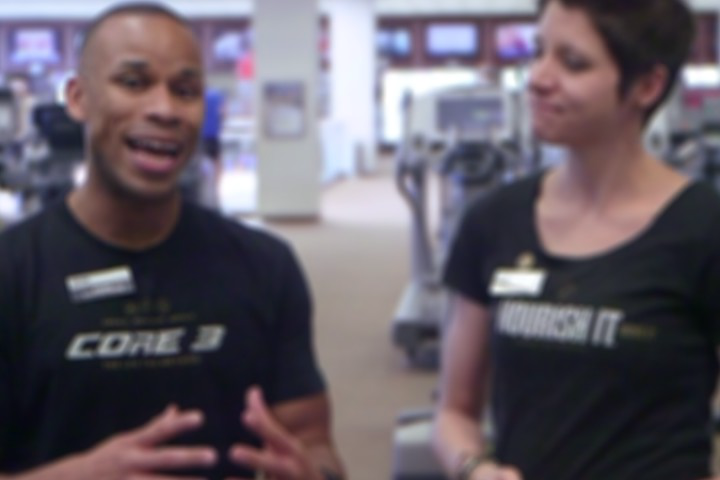

In [21]:
#test the CropRescale transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (480,720),
                  kernel_range=(1,16), 
                  quality_range=(90,90), 
                  slope_range=(0.0001, 0.1),
                 radius_range=(.05,.5),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [22]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.00001, 0.01),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2)), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])



def test_input_transform(crop_size, kernel_size, quality):
    
    return Compose([
        Crappify(crop_size=crop_size, kernel_size=kernel_size, quality=quality),
        ToTensor()
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, kernel_size, quality, frame_sample_size=10):


    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=test_input_transform(
                                 crop_size, kernel_size, quality),
                             target_transform=ToTensor(),
                             add_noise=None,
                             noise_std=3,Flip_hor=False,
                             Rand_bright_contrast=False)

In [23]:
#settings
train_dir = "/media/SSD/superres/video_data/train_data"
frame_sample_size =10
batch_size = 1 # Make 4 For FP16, 480x720 size images
#crop_size = (480,720)
crop_size = (240,320)
kernel_range=(1,20)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [24]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [25]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(240, 320)


In [24]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [25]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    print(inputs.shape)
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

In [26]:
show_batch(training_data_loader,size =8)

NameError: name 'training_data_loader' is not defined

# VDSR with dropout

In [ ]:
import torch.nn as nn
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.do = nn.Dropout2d(p=0.5, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class VDSRNet(nn.Module):
    def __init__(self):
        super(VDSRNet, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out
    
    


# ESPCN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))


class ESPCNNet(nn.Module):
    def __init__(self, upscale_factor):
        super(ESPCNNet, self).__init__()

        self.upscale_factor = upscale_factor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1a = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv1b = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv1c = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv1d = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv2 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(32, 1 * (upscale_factor ** 2), (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.relu = nn.ReLU(inplace=True)
        

    def forward(self, x):
        
        #residual = x
        #residual = F.interpolate(x, size=None, scale_factor=self.upscale_factor, mode='bicubic',
        #                         align_corners=True, recompute_scale_factor=None).clamp(min=0.0, max=1.0)
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.relu(self.conv1c(x))
        x = self.relu(self.conv1d(x))
        x = self.relu(self.conv2(x))
        x = F.sigmoid(self.pixel_shuffle(self.conv3(x)))
        
        #x = torch.add(x,residual)
        
        return x
    
# Make it use a residual approach -Add the network to bicubic interpolation at end resolution - just like VDSR

# RCAN

In [27]:
# common

import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class MeanShift(nn.Conv2d):
    def __init__(self, rgb_range, rgb_mean, rgb_std, sign=-1):
        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1)
        self.weight.data.div_(std.view(3, 1, 1, 1))
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean)
        self.bias.data.div_(std)
        self.requires_grad = False

class BasicBlock(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, bias=False,
        bn=True, act=nn.ReLU(True)):

        m = [nn.Conv2d(
            in_channels, out_channels, kernel_size,
            padding=(kernel_size//2), stride=stride, bias=bias)
        ]
        if bn: m.append(nn.BatchNorm2d(out_channels))
        if act is not None: m.append(act)
        super(BasicBlock, self).__init__(*m)

class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if i == 0: m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feat, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feat, 4 * n_feat, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn: m.append(nn.BatchNorm2d(n_feat))
                if act: m.append(act())
        elif scale == 3:
            m.append(conv(n_feat, 9 * n_feat, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if act: m.append(act())
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)

In [28]:
import torch.nn as nn

def make_model(args, parent=False):
    return RCAN(args)

## Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

## Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size, reduction,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(RCAB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: modules_body.append(nn.BatchNorm2d(n_feat))
            if i == 0: modules_body.append(act)
        modules_body.append(CALayer(n_feat, reduction))
        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x)
        #res = self.body(x).mul(self.res_scale)
        res += x
        return res

## Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, act, res_scale, n_resblocks):
        super(ResidualGroup, self).__init__()
        modules_body = []
        modules_body = [
            RCAB(
                conv, n_feat, kernel_size, reduction, bias=True, bn=False, act=nn.ReLU(True), res_scale=1) \
            for _ in range(n_resblocks)]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

## Residual Channel Attention Network (RCAN)
class RCAN(nn.Module):
    def __init__(self, args, conv=default_conv):
        super(RCAN, self).__init__()
        
        n_resgroups = args.n_resgroups
        n_resblocks = args.n_resblocks
        n_feats = args.n_feats
        kernel_size = 3
        reduction = args.reduction 
        scale = args.scale[0]
        act = nn.ReLU(True)
        
        # RGB mean for DIV2K
        rgb_mean = (0.4488, 0.4371, 0.4040)
        rgb_std = (1.0, 1.0, 1.0)
        self.sub_mean = MeanShift(args.rgb_range, rgb_mean, rgb_std)
        
        # define head module
        modules_head = [conv(args.n_colors, n_feats, kernel_size)]

        # define body module
        modules_body = [
            ResidualGroup(
                conv, n_feats, kernel_size, reduction, act=act, res_scale=args.res_scale, n_resblocks=n_resblocks) \
            for _ in range(n_resgroups)]

        modules_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        modules_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, args.n_colors, kernel_size)]

        self.add_mean = MeanShift(args.rgb_range, rgb_mean, rgb_std, 1)

        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.tail = nn.Sequential(*modules_tail)

    def forward(self, x):
        #removing for single channel
        #x = self.sub_mean(x)
        x = self.head(x)

        res = self.body(x)
        res += x

        x = self.tail(res)
        #remove for single channel images
        #x = self.add_mean(x)

        return x 

    def load_state_dict(self, state_dict, strict=False):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                if isinstance(param, nn.Parameter):
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    if name.find('tail') >= 0:
                        print('Replace pre-trained upsampler to new one...')
                    else:
                        raise RuntimeError('While copying the parameter named {}, '
                                           'whose dimensions in the model are {} and '
                                           'whose dimensions in the checkpoint are {}.'
                                           .format(name, own_state[name].size(), param.size()))
            elif strict:
                if name.find('tail') == -1:
                    raise KeyError('unexpected key "{}" in state_dict'
                                   .format(name))

        if strict:
            missing = set(own_state.keys()) - set(state_dict.keys())
            if len(missing) > 0:
                raise KeyError('missing keys in state_dict: "{}"'.format(missing))

# Build the model

In [31]:
from types import SimpleNamespace

args = SimpleNamespace()

args.n_resgroups = 5 # was 10
args.n_resblocks = 10 # was 20
args.n_feats = 64
args.reduction = 16
args.scale = (1,0)
args.rgb_range = 255
args.n_colors = 1
args.res_scale = 1


In [32]:
#model = VDSRNet()
#model = ESPCNNet(upscale_factor=1)
model = RCAN(args)
model.cuda()


RCAN(
  (sub_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (add_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (head): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (body): Sequential(
    (0): ResidualGroup(
      (body): Sequential(
        (0): RCAB(
          (body): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): CALayer(
              (avg_pool): AdaptiveAvgPool2d(output_size=1)
              (conv_du): Sequential(
                (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
                (1): ReLU(inplace=True)
                (2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
                (3): Sigmoid()
              )
            )
          )
        )
        (1): RCAB(
          (body): Sequential(
       

In [33]:
#model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]



In [34]:
criterion = nn.MSELoss(reduction = 'sum')


In [35]:
init_lr = .001
lr_step = 2
gradient_clip = 0.4
epochs = 10

In [36]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)

In [37]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [38]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [39]:
def save_checkpoint(experiment, model, epoch):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [40]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [41]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()
        
        # Runs the forward pass with autocasting.
        with autocast():
            output = model(input)
            #loss = criterion(output, target) + criterion2(output, target)/5000.0
            loss = criterion(output, target)
            
        
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
    print("Epoch Loss:", cum_loss2/ct2)        

In [42]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch)

Start Time: 2020-10-02 19:31:50.651506
Epoch = 1, lr = 0.001
===> Time: 2020-10-02 19:31:54.087009 Epoch[1](10/6343): LR: 0.001 : Loss: 8740.0957031250
===> Time: 2020-10-02 19:31:57.444002 Epoch[1](20/6343): LR: 0.001 : Loss: 2112309.7500000000
===> Time: 2020-10-02 19:32:00.846921 Epoch[1](30/6343): LR: 0.001 : Loss: 2054040.6250000000
===> Time: 2020-10-02 19:32:04.401978 Epoch[1](40/6343): LR: 0.001 : Loss: 17829.6914062500
===> Time: 2020-10-02 19:32:07.990114 Epoch[1](50/6343): LR: 0.001 : Loss: 3817.2480468750
===> Time: 2020-10-02 19:32:11.481815 Epoch[1](60/6343): LR: 0.001 : Loss: 2419.6171875000
===> Time: 2020-10-02 19:32:15.036097 Epoch[1](70/6343): LR: 0.001 : Loss: 1573.7598876953
===> Time: 2020-10-02 19:32:18.617281 Epoch[1](80/6343): LR: 0.001 : Loss: 1316.8924560547
===> Time: 2020-10-02 19:32:22.123625 Epoch[1](90/6343): LR: 0.001 : Loss: 1002.2750244141
===> Time: 2020-10-02 19:32:25.717364 Epoch[1](100/6343): LR: 0.001 : Loss: 988.1325073242
===> Time: 2020-10-02 

===> Time: 2020-10-02 19:37:16.912170 Epoch[1](910/6343): LR: 0.001 : Loss: 716.8706054688
===> Time: 2020-10-02 19:37:20.533033 Epoch[1](920/6343): LR: 0.001 : Loss: 424.1384277344
===> Time: 2020-10-02 19:37:24.090602 Epoch[1](930/6343): LR: 0.001 : Loss: 388.8049011230
===> Time: 2020-10-02 19:37:27.634673 Epoch[1](940/6343): LR: 0.001 : Loss: 1168.7664794922
===> Time: 2020-10-02 19:37:31.235377 Epoch[1](950/6343): LR: 0.001 : Loss: 539.8517456055
===> Time: 2020-10-02 19:37:34.795905 Epoch[1](960/6343): LR: 0.001 : Loss: 575.8546142578
===> Time: 2020-10-02 19:37:38.309387 Epoch[1](970/6343): LR: 0.001 : Loss: 765.4861450195
===> Time: 2020-10-02 19:37:41.841497 Epoch[1](980/6343): LR: 0.001 : Loss: 499.2497253418
===> Time: 2020-10-02 19:37:45.471991 Epoch[1](990/6343): LR: 0.001 : Loss: 1246.2833251953
===> Time: 2020-10-02 19:37:48.994292 Epoch[1](1000/6343): LR: 0.001 : Loss: 476.4612426758
===> Time: 2020-10-02 19:37:52.500319 Epoch[1](1010/6343): LR: 0.001 : Loss: 1082.40136

===> Time: 2020-10-02 19:42:32.739429 Epoch[1](1800/6343): LR: 0.001 : Loss: 587.3576049805
===> Time: 2020-10-02 19:42:36.235842 Epoch[1](1810/6343): LR: 0.001 : Loss: 809.6977539062
===> Time: 2020-10-02 19:42:39.807853 Epoch[1](1820/6343): LR: 0.001 : Loss: 553.7346801758
===> Time: 2020-10-02 19:42:43.285327 Epoch[1](1830/6343): LR: 0.001 : Loss: 693.9295043945
===> Time: 2020-10-02 19:42:46.809694 Epoch[1](1840/6343): LR: 0.001 : Loss: 560.0836791992
===> Time: 2020-10-02 19:42:50.398418 Epoch[1](1850/6343): LR: 0.001 : Loss: 733.7070312500
===> Time: 2020-10-02 19:42:53.968966 Epoch[1](1860/6343): LR: 0.001 : Loss: 592.0883178711
===> Time: 2020-10-02 19:42:57.496574 Epoch[1](1870/6343): LR: 0.001 : Loss: 596.9191894531
===> Time: 2020-10-02 19:43:01.177271 Epoch[1](1880/6343): LR: 0.001 : Loss: 749.8197631836
===> Time: 2020-10-02 19:43:04.770982 Epoch[1](1890/6343): LR: 0.001 : Loss: 426.4394531250
===> Time: 2020-10-02 19:43:08.280609 Epoch[1](1900/6343): LR: 0.001 : Loss: 960

===> Time: 2020-10-02 19:47:47.881713 Epoch[1](2690/6343): LR: 0.001 : Loss: 806.8269042969
===> Time: 2020-10-02 19:47:51.390705 Epoch[1](2700/6343): LR: 0.001 : Loss: 546.1871948242
===> Time: 2020-10-02 19:47:54.938570 Epoch[1](2710/6343): LR: 0.001 : Loss: 1490.5413818359
===> Time: 2020-10-02 19:47:58.426886 Epoch[1](2720/6343): LR: 0.001 : Loss: 433.6327819824
===> Time: 2020-10-02 19:48:01.955356 Epoch[1](2730/6343): LR: 0.001 : Loss: 1335.1961669922
===> Time: 2020-10-02 19:48:05.493042 Epoch[1](2740/6343): LR: 0.001 : Loss: 966.0734252930
===> Time: 2020-10-02 19:48:09.076418 Epoch[1](2750/6343): LR: 0.001 : Loss: 753.1975097656
===> Time: 2020-10-02 19:48:12.644671 Epoch[1](2760/6343): LR: 0.001 : Loss: 1343.5863037109
===> Time: 2020-10-02 19:48:16.302537 Epoch[1](2770/6343): LR: 0.001 : Loss: 860.1690673828
===> Time: 2020-10-02 19:48:19.945736 Epoch[1](2780/6343): LR: 0.001 : Loss: 659.4406127930
===> Time: 2020-10-02 19:48:23.524858 Epoch[1](2790/6343): LR: 0.001 : Loss: 

===> Time: 2020-10-02 19:53:01.938343 Epoch[1](3580/6343): LR: 0.001 : Loss: 661.2824096680
===> Time: 2020-10-02 19:53:05.512725 Epoch[1](3590/6343): LR: 0.001 : Loss: 1203.1021728516
===> Time: 2020-10-02 19:53:09.048434 Epoch[1](3600/6343): LR: 0.001 : Loss: 285.3692321777
===> Time: 2020-10-02 19:53:12.579249 Epoch[1](3610/6343): LR: 0.001 : Loss: 647.9524536133
===> Time: 2020-10-02 19:53:16.225116 Epoch[1](3620/6343): LR: 0.001 : Loss: 412.5750122070
===> Time: 2020-10-02 19:53:19.678028 Epoch[1](3630/6343): LR: 0.001 : Loss: 876.1231689453
===> Time: 2020-10-02 19:53:23.210931 Epoch[1](3640/6343): LR: 0.001 : Loss: 479.6864318848
===> Time: 2020-10-02 19:53:26.633264 Epoch[1](3650/6343): LR: 0.001 : Loss: 737.3132934570
===> Time: 2020-10-02 19:53:30.046595 Epoch[1](3660/6343): LR: 0.001 : Loss: 379.2757263184
===> Time: 2020-10-02 19:53:33.751916 Epoch[1](3670/6343): LR: 0.001 : Loss: 625.9653320312
===> Time: 2020-10-02 19:53:37.138917 Epoch[1](3680/6343): LR: 0.001 : Loss: 49

===> Time: 2020-10-02 19:58:15.060330 Epoch[1](4470/6343): LR: 0.001 : Loss: 814.7654418945
===> Time: 2020-10-02 19:58:18.709130 Epoch[1](4480/6343): LR: 0.001 : Loss: 630.6652221680
===> Time: 2020-10-02 19:58:22.211932 Epoch[1](4490/6343): LR: 0.001 : Loss: 479.3760681152
===> Time: 2020-10-02 19:58:25.715338 Epoch[1](4500/6343): LR: 0.001 : Loss: 722.1237182617
===> Time: 2020-10-02 19:58:29.201871 Epoch[1](4510/6343): LR: 0.001 : Loss: 1333.9339599609
===> Time: 2020-10-02 19:58:32.651605 Epoch[1](4520/6343): LR: 0.001 : Loss: 2949.5681152344
===> Time: 2020-10-02 19:58:36.225518 Epoch[1](4530/6343): LR: 0.001 : Loss: 586.7120361328
===> Time: 2020-10-02 19:58:39.756730 Epoch[1](4540/6343): LR: 0.001 : Loss: 1995.3433837891
===> Time: 2020-10-02 19:58:43.291051 Epoch[1](4550/6343): LR: 0.001 : Loss: 2196.8786621094
===> Time: 2020-10-02 19:58:46.840594 Epoch[1](4560/6343): LR: 0.001 : Loss: 996.0562744141
===> Time: 2020-10-02 19:58:50.321744 Epoch[1](4570/6343): LR: 0.001 : Loss:

===> Time: 2020-10-02 20:03:29.399187 Epoch[1](5360/6343): LR: 0.001 : Loss: 472.6384277344
===> Time: 2020-10-02 20:03:32.910133 Epoch[1](5370/6343): LR: 0.001 : Loss: 415.7763671875
===> Time: 2020-10-02 20:03:36.433036 Epoch[1](5380/6343): LR: 0.001 : Loss: 711.2968750000
===> Time: 2020-10-02 20:03:39.916765 Epoch[1](5390/6343): LR: 0.001 : Loss: 1173.0161132812
===> Time: 2020-10-02 20:03:43.452246 Epoch[1](5400/6343): LR: 0.001 : Loss: 721.2372436523
===> Time: 2020-10-02 20:03:46.942543 Epoch[1](5410/6343): LR: 0.001 : Loss: 1080.6787109375
===> Time: 2020-10-02 20:03:50.458873 Epoch[1](5420/6343): LR: 0.001 : Loss: 1445.0986328125
===> Time: 2020-10-02 20:03:53.944859 Epoch[1](5430/6343): LR: 0.001 : Loss: 486.3320007324
===> Time: 2020-10-02 20:03:57.408142 Epoch[1](5440/6343): LR: 0.001 : Loss: 871.7783203125
===> Time: 2020-10-02 20:04:00.955875 Epoch[1](5450/6343): LR: 0.001 : Loss: 707.1596069336
===> Time: 2020-10-02 20:04:04.428177 Epoch[1](5460/6343): LR: 0.001 : Loss: 

===> Time: 2020-10-02 20:08:42.023473 Epoch[1](6250/6343): LR: 0.001 : Loss: 829.5863647461
===> Time: 2020-10-02 20:08:45.536882 Epoch[1](6260/6343): LR: 0.001 : Loss: 597.9348754883
===> Time: 2020-10-02 20:08:48.985211 Epoch[1](6270/6343): LR: 0.001 : Loss: 459.0909729004
===> Time: 2020-10-02 20:08:52.565712 Epoch[1](6280/6343): LR: 0.001 : Loss: 259.4548950195
===> Time: 2020-10-02 20:08:56.062994 Epoch[1](6290/6343): LR: 0.001 : Loss: 566.3264770508
===> Time: 2020-10-02 20:08:59.541670 Epoch[1](6300/6343): LR: 0.001 : Loss: 1312.2735595703
===> Time: 2020-10-02 20:09:03.023674 Epoch[1](6310/6343): LR: 0.001 : Loss: 592.2008666992
===> Time: 2020-10-02 20:09:06.480445 Epoch[1](6320/6343): LR: 0.001 : Loss: 707.6300048828
===> Time: 2020-10-02 20:09:09.945101 Epoch[1](6330/6343): LR: 0.001 : Loss: 474.1452636719
===> Time: 2020-10-02 20:09:13.368044 Epoch[1](6340/6343): LR: 0.001 : Loss: 310.7311096191
Epoch Loss: tensor(7709.9932, device='cuda:0')
Checkpoint saved to /media/SSD/s

===> Time: 2020-10-02 20:13:49.618087 Epoch[2](790/6343): LR: 0.001 : Loss: 649.9418334961
===> Time: 2020-10-02 20:13:53.118659 Epoch[2](800/6343): LR: 0.001 : Loss: 825.6399536133
===> Time: 2020-10-02 20:13:56.605455 Epoch[2](810/6343): LR: 0.001 : Loss: 604.0042114258
===> Time: 2020-10-02 20:14:00.076655 Epoch[2](820/6343): LR: 0.001 : Loss: 763.5269775391
===> Time: 2020-10-02 20:14:03.555613 Epoch[2](830/6343): LR: 0.001 : Loss: 788.6591186523
===> Time: 2020-10-02 20:14:07.061853 Epoch[2](840/6343): LR: 0.001 : Loss: 764.9887695312
===> Time: 2020-10-02 20:14:10.545648 Epoch[2](850/6343): LR: 0.001 : Loss: 1026.8336181641
===> Time: 2020-10-02 20:14:13.991900 Epoch[2](860/6343): LR: 0.001 : Loss: 826.1090698242
===> Time: 2020-10-02 20:14:17.460577 Epoch[2](870/6343): LR: 0.001 : Loss: 726.8397216797
===> Time: 2020-10-02 20:14:21.031869 Epoch[2](880/6343): LR: 0.001 : Loss: 876.7297973633
===> Time: 2020-10-02 20:14:24.642644 Epoch[2](890/6343): LR: 0.001 : Loss: 547.104492187

===> Time: 2020-10-02 20:19:04.501641 Epoch[2](1690/6343): LR: 0.001 : Loss: 717.5632934570
===> Time: 2020-10-02 20:19:07.996142 Epoch[2](1700/6343): LR: 0.001 : Loss: 1045.9677734375
===> Time: 2020-10-02 20:19:11.456640 Epoch[2](1710/6343): LR: 0.001 : Loss: 446.6223144531
===> Time: 2020-10-02 20:19:15.008810 Epoch[2](1720/6343): LR: 0.001 : Loss: 470.4168090820
===> Time: 2020-10-02 20:19:18.486705 Epoch[2](1730/6343): LR: 0.001 : Loss: 788.2637939453
===> Time: 2020-10-02 20:19:21.977949 Epoch[2](1740/6343): LR: 0.001 : Loss: 933.6914062500
===> Time: 2020-10-02 20:19:25.474878 Epoch[2](1750/6343): LR: 0.001 : Loss: 389.7918395996
===> Time: 2020-10-02 20:19:28.940855 Epoch[2](1760/6343): LR: 0.001 : Loss: 690.2202148438
===> Time: 2020-10-02 20:19:32.432206 Epoch[2](1770/6343): LR: 0.001 : Loss: 1396.7945556641
===> Time: 2020-10-02 20:19:35.947828 Epoch[2](1780/6343): LR: 0.001 : Loss: 389.1864013672
===> Time: 2020-10-02 20:19:39.420645 Epoch[2](1790/6343): LR: 0.001 : Loss: 5

===> Time: 2020-10-02 20:24:17.478753 Epoch[2](2580/6343): LR: 0.001 : Loss: 681.8953247070
===> Time: 2020-10-02 20:24:21.022075 Epoch[2](2590/6343): LR: 0.001 : Loss: 749.6022338867
===> Time: 2020-10-02 20:24:24.700198 Epoch[2](2600/6343): LR: 0.001 : Loss: 1268.5477294922
===> Time: 2020-10-02 20:24:28.426281 Epoch[2](2610/6343): LR: 0.001 : Loss: 960.1593627930
===> Time: 2020-10-02 20:24:32.026029 Epoch[2](2620/6343): LR: 0.001 : Loss: 739.2999267578
===> Time: 2020-10-02 20:24:35.788003 Epoch[2](2630/6343): LR: 0.001 : Loss: 549.9955444336
===> Time: 2020-10-02 20:24:39.470922 Epoch[2](2640/6343): LR: 0.001 : Loss: 575.7656250000
===> Time: 2020-10-02 20:24:43.033295 Epoch[2](2650/6343): LR: 0.001 : Loss: 1575.1174316406
===> Time: 2020-10-02 20:24:46.634973 Epoch[2](2660/6343): LR: 0.001 : Loss: 574.8093872070
===> Time: 2020-10-02 20:24:50.344267 Epoch[2](2670/6343): LR: 0.001 : Loss: 367.0638732910
===> Time: 2020-10-02 20:24:54.118513 Epoch[2](2680/6343): LR: 0.001 : Loss: 6

===> Time: 2020-10-02 20:29:31.092414 Epoch[2](3470/6343): LR: 0.001 : Loss: 664.0023193359
===> Time: 2020-10-02 20:29:34.630539 Epoch[2](3480/6343): LR: 0.001 : Loss: 757.1383666992
===> Time: 2020-10-02 20:29:38.130051 Epoch[2](3490/6343): LR: 0.001 : Loss: 597.7648925781
===> Time: 2020-10-02 20:29:41.582817 Epoch[2](3500/6343): LR: 0.001 : Loss: 369.8635253906
===> Time: 2020-10-02 20:29:45.094453 Epoch[2](3510/6343): LR: 0.001 : Loss: 631.5202026367
===> Time: 2020-10-02 20:29:48.488351 Epoch[2](3520/6343): LR: 0.001 : Loss: 529.8079833984
===> Time: 2020-10-02 20:29:51.958022 Epoch[2](3530/6343): LR: 0.001 : Loss: 478.7566528320
===> Time: 2020-10-02 20:29:55.478627 Epoch[2](3540/6343): LR: 0.001 : Loss: 374.6571960449
===> Time: 2020-10-02 20:29:59.052677 Epoch[2](3550/6343): LR: 0.001 : Loss: 1705.4432373047
===> Time: 2020-10-02 20:30:02.536076 Epoch[2](3560/6343): LR: 0.001 : Loss: 565.9364624023
===> Time: 2020-10-02 20:30:06.039742 Epoch[2](3570/6343): LR: 0.001 : Loss: 39

===> Time: 2020-10-02 20:34:40.986101 Epoch[2](4360/6343): LR: 0.001 : Loss: 548.9671630859
===> Time: 2020-10-02 20:34:44.509443 Epoch[2](4370/6343): LR: 0.001 : Loss: 605.9605712891
===> Time: 2020-10-02 20:34:47.986358 Epoch[2](4380/6343): LR: 0.001 : Loss: 517.1610107422
===> Time: 2020-10-02 20:34:51.463970 Epoch[2](4390/6343): LR: 0.001 : Loss: 757.1517944336
===> Time: 2020-10-02 20:34:54.912104 Epoch[2](4400/6343): LR: 0.001 : Loss: 616.4299926758
===> Time: 2020-10-02 20:34:58.358441 Epoch[2](4410/6343): LR: 0.001 : Loss: 293.7695007324
===> Time: 2020-10-02 20:35:01.791427 Epoch[2](4420/6343): LR: 0.001 : Loss: 573.7681884766
===> Time: 2020-10-02 20:35:05.273651 Epoch[2](4430/6343): LR: 0.001 : Loss: 878.2238159180
===> Time: 2020-10-02 20:35:08.679511 Epoch[2](4440/6343): LR: 0.001 : Loss: 782.0753173828
===> Time: 2020-10-02 20:35:12.214791 Epoch[2](4450/6343): LR: 0.001 : Loss: 597.6051025391
===> Time: 2020-10-02 20:35:15.751705 Epoch[2](4460/6343): LR: 0.001 : Loss: 658

===> Time: 2020-10-02 20:39:51.825003 Epoch[2](5250/6343): LR: 0.001 : Loss: 2058.2248535156
===> Time: 2020-10-02 20:39:55.319536 Epoch[2](5260/6343): LR: 0.001 : Loss: 1204.7968750000
===> Time: 2020-10-02 20:39:58.769260 Epoch[2](5270/6343): LR: 0.001 : Loss: 4562.6372070312
===> Time: 2020-10-02 20:40:02.211643 Epoch[2](5280/6343): LR: 0.001 : Loss: 2600.5690917969
===> Time: 2020-10-02 20:40:05.719206 Epoch[2](5290/6343): LR: 0.001 : Loss: 991.9581298828
===> Time: 2020-10-02 20:40:09.191884 Epoch[2](5300/6343): LR: 0.001 : Loss: 1535.4309082031
===> Time: 2020-10-02 20:40:12.679653 Epoch[2](5310/6343): LR: 0.001 : Loss: 1063.7524414062
===> Time: 2020-10-02 20:40:16.217140 Epoch[2](5320/6343): LR: 0.001 : Loss: 1681.6878662109
===> Time: 2020-10-02 20:40:19.733066 Epoch[2](5330/6343): LR: 0.001 : Loss: 2721.8686523438
===> Time: 2020-10-02 20:40:23.167712 Epoch[2](5340/6343): LR: 0.001 : Loss: 6836.1000976562
===> Time: 2020-10-02 20:40:26.725296 Epoch[2](5350/6343): LR: 0.001 : 

===> Time: 2020-10-02 20:45:04.781864 Epoch[2](6140/6343): LR: 0.001 : Loss: 1144.4769287109
===> Time: 2020-10-02 20:45:08.384139 Epoch[2](6150/6343): LR: 0.001 : Loss: 543.9357299805
===> Time: 2020-10-02 20:45:11.912943 Epoch[2](6160/6343): LR: 0.001 : Loss: 1106.4755859375
===> Time: 2020-10-02 20:45:15.497060 Epoch[2](6170/6343): LR: 0.001 : Loss: 571.6474609375
===> Time: 2020-10-02 20:45:18.883320 Epoch[2](6180/6343): LR: 0.001 : Loss: 702.2305908203
===> Time: 2020-10-02 20:45:22.505742 Epoch[2](6190/6343): LR: 0.001 : Loss: 489.1795043945
===> Time: 2020-10-02 20:45:26.123694 Epoch[2](6200/6343): LR: 0.001 : Loss: 471.0804748535
===> Time: 2020-10-02 20:45:29.641302 Epoch[2](6210/6343): LR: 0.001 : Loss: 1269.4748535156
===> Time: 2020-10-02 20:45:33.155041 Epoch[2](6220/6343): LR: 0.001 : Loss: 542.1677856445
===> Time: 2020-10-02 20:45:36.703800 Epoch[2](6230/6343): LR: 0.001 : Loss: 430.6380004883
===> Time: 2020-10-02 20:45:40.330301 Epoch[2](6240/6343): LR: 0.001 : Loss: 

===> Time: 2020-10-02 20:49:43.328903 Epoch[3](580/6343): LR: 0.00031622776601683794 : Loss: 387.2266235352
===> Time: 2020-10-02 20:49:47.016100 Epoch[3](590/6343): LR: 0.00031622776601683794 : Loss: 562.2934570312
===> Time: 2020-10-02 20:49:50.602770 Epoch[3](600/6343): LR: 0.00031622776601683794 : Loss: 721.6920776367
===> Time: 2020-10-02 20:49:54.029154 Epoch[3](610/6343): LR: 0.00031622776601683794 : Loss: 563.2559814453
===> Time: 2020-10-02 20:49:57.480796 Epoch[3](620/6343): LR: 0.00031622776601683794 : Loss: 420.3572387695
===> Time: 2020-10-02 20:50:01.012722 Epoch[3](630/6343): LR: 0.00031622776601683794 : Loss: 348.0144958496
===> Time: 2020-10-02 20:50:04.568627 Epoch[3](640/6343): LR: 0.00031622776601683794 : Loss: 1281.6489257812
===> Time: 2020-10-02 20:50:08.090953 Epoch[3](650/6343): LR: 0.00031622776601683794 : Loss: 425.5130004883
===> Time: 2020-10-02 20:50:11.607509 Epoch[3](660/6343): LR: 0.00031622776601683794 : Loss: 696.2140502930
===> Time: 2020-10-02 20:50

===> Time: 2020-10-02 20:54:12.742027 Epoch[3](1340/6343): LR: 0.00031622776601683794 : Loss: 464.2975769043
===> Time: 2020-10-02 20:54:16.194299 Epoch[3](1350/6343): LR: 0.00031622776601683794 : Loss: 680.7366333008
===> Time: 2020-10-02 20:54:19.928680 Epoch[3](1360/6343): LR: 0.00031622776601683794 : Loss: 548.5734252930
===> Time: 2020-10-02 20:54:23.603792 Epoch[3](1370/6343): LR: 0.00031622776601683794 : Loss: 670.3627319336
===> Time: 2020-10-02 20:54:27.160040 Epoch[3](1380/6343): LR: 0.00031622776601683794 : Loss: 695.8291015625
===> Time: 2020-10-02 20:54:30.636438 Epoch[3](1390/6343): LR: 0.00031622776601683794 : Loss: 582.4644775391
===> Time: 2020-10-02 20:54:34.069286 Epoch[3](1400/6343): LR: 0.00031622776601683794 : Loss: 587.2521362305
===> Time: 2020-10-02 20:54:37.650443 Epoch[3](1410/6343): LR: 0.00031622776601683794 : Loss: 531.3314819336
===> Time: 2020-10-02 20:54:41.189693 Epoch[3](1420/6343): LR: 0.00031622776601683794 : Loss: 508.6645507812
===> Time: 2020-10-

===> Time: 2020-10-02 20:58:41.471924 Epoch[3](2100/6343): LR: 0.00031622776601683794 : Loss: 747.8605957031
===> Time: 2020-10-02 20:58:45.196613 Epoch[3](2110/6343): LR: 0.00031622776601683794 : Loss: 813.6920166016
===> Time: 2020-10-02 20:58:48.743236 Epoch[3](2120/6343): LR: 0.00031622776601683794 : Loss: 441.6895446777
===> Time: 2020-10-02 20:58:52.287535 Epoch[3](2130/6343): LR: 0.00031622776601683794 : Loss: 604.7858276367
===> Time: 2020-10-02 20:58:55.805986 Epoch[3](2140/6343): LR: 0.00031622776601683794 : Loss: 671.0379638672
===> Time: 2020-10-02 20:58:59.232147 Epoch[3](2150/6343): LR: 0.00031622776601683794 : Loss: 529.2324829102
===> Time: 2020-10-02 20:59:02.696130 Epoch[3](2160/6343): LR: 0.00031622776601683794 : Loss: 625.8542480469
===> Time: 2020-10-02 20:59:06.188507 Epoch[3](2170/6343): LR: 0.00031622776601683794 : Loss: 508.1563110352
===> Time: 2020-10-02 20:59:09.765195 Epoch[3](2180/6343): LR: 0.00031622776601683794 : Loss: 642.9486083984
===> Time: 2020-10-

===> Time: 2020-10-02 21:03:13.233845 Epoch[3](2860/6343): LR: 0.00031622776601683794 : Loss: 570.0537109375
===> Time: 2020-10-02 21:03:16.782580 Epoch[3](2870/6343): LR: 0.00031622776601683794 : Loss: 573.7316284180
===> Time: 2020-10-02 21:03:20.302481 Epoch[3](2880/6343): LR: 0.00031622776601683794 : Loss: 499.0209960938
===> Time: 2020-10-02 21:03:23.851264 Epoch[3](2890/6343): LR: 0.00031622776601683794 : Loss: 569.1262207031
===> Time: 2020-10-02 21:03:27.519911 Epoch[3](2900/6343): LR: 0.00031622776601683794 : Loss: 618.4129638672
===> Time: 2020-10-02 21:03:31.086127 Epoch[3](2910/6343): LR: 0.00031622776601683794 : Loss: 818.2809448242
===> Time: 2020-10-02 21:03:34.588171 Epoch[3](2920/6343): LR: 0.00031622776601683794 : Loss: 613.1256713867
===> Time: 2020-10-02 21:03:38.110721 Epoch[3](2930/6343): LR: 0.00031622776601683794 : Loss: 495.8396911621
===> Time: 2020-10-02 21:03:41.650137 Epoch[3](2940/6343): LR: 0.00031622776601683794 : Loss: 556.6995239258
===> Time: 2020-10-

===> Time: 2020-10-02 21:07:41.907051 Epoch[3](3620/6343): LR: 0.00031622776601683794 : Loss: 1148.1257324219
===> Time: 2020-10-02 21:07:45.388553 Epoch[3](3630/6343): LR: 0.00031622776601683794 : Loss: 382.4601745605
===> Time: 2020-10-02 21:07:48.824599 Epoch[3](3640/6343): LR: 0.00031622776601683794 : Loss: 633.1729125977
===> Time: 2020-10-02 21:07:52.305144 Epoch[3](3650/6343): LR: 0.00031622776601683794 : Loss: 561.8117065430
===> Time: 2020-10-02 21:07:55.801798 Epoch[3](3660/6343): LR: 0.00031622776601683794 : Loss: 541.8071289062
===> Time: 2020-10-02 21:07:59.305487 Epoch[3](3670/6343): LR: 0.00031622776601683794 : Loss: 753.3731689453
===> Time: 2020-10-02 21:08:02.877884 Epoch[3](3680/6343): LR: 0.00031622776601683794 : Loss: 370.6378784180
===> Time: 2020-10-02 21:08:06.425335 Epoch[3](3690/6343): LR: 0.00031622776601683794 : Loss: 682.4773559570
===> Time: 2020-10-02 21:08:10.009771 Epoch[3](3700/6343): LR: 0.00031622776601683794 : Loss: 880.5307006836
===> Time: 2020-10

===> Time: 2020-10-02 21:12:09.986987 Epoch[3](4380/6343): LR: 0.00031622776601683794 : Loss: 737.1652221680
===> Time: 2020-10-02 21:12:13.408304 Epoch[3](4390/6343): LR: 0.00031622776601683794 : Loss: 510.6963806152
===> Time: 2020-10-02 21:12:16.926863 Epoch[3](4400/6343): LR: 0.00031622776601683794 : Loss: 420.9718322754
===> Time: 2020-10-02 21:12:20.361922 Epoch[3](4410/6343): LR: 0.00031622776601683794 : Loss: 599.3794555664
===> Time: 2020-10-02 21:12:23.912794 Epoch[3](4420/6343): LR: 0.00031622776601683794 : Loss: 422.9439392090
===> Time: 2020-10-02 21:12:27.405198 Epoch[3](4430/6343): LR: 0.00031622776601683794 : Loss: 456.7972106934
===> Time: 2020-10-02 21:12:30.905262 Epoch[3](4440/6343): LR: 0.00031622776601683794 : Loss: 519.5571289062
===> Time: 2020-10-02 21:12:34.452375 Epoch[3](4450/6343): LR: 0.00031622776601683794 : Loss: 809.2958984375
===> Time: 2020-10-02 21:12:37.901835 Epoch[3](4460/6343): LR: 0.00031622776601683794 : Loss: 559.3321533203
===> Time: 2020-10-

===> Time: 2020-10-02 21:16:36.208226 Epoch[3](5140/6343): LR: 0.00031622776601683794 : Loss: 539.0734863281
===> Time: 2020-10-02 21:16:39.657018 Epoch[3](5150/6343): LR: 0.00031622776601683794 : Loss: 787.6195678711
===> Time: 2020-10-02 21:16:43.146570 Epoch[3](5160/6343): LR: 0.00031622776601683794 : Loss: 800.7035522461
===> Time: 2020-10-02 21:16:46.618497 Epoch[3](5170/6343): LR: 0.00031622776601683794 : Loss: 962.2553100586
===> Time: 2020-10-02 21:16:50.111137 Epoch[3](5180/6343): LR: 0.00031622776601683794 : Loss: 526.8302612305
===> Time: 2020-10-02 21:16:53.687938 Epoch[3](5190/6343): LR: 0.00031622776601683794 : Loss: 485.0412292480
===> Time: 2020-10-02 21:16:57.179090 Epoch[3](5200/6343): LR: 0.00031622776601683794 : Loss: 353.3240051270
===> Time: 2020-10-02 21:17:00.628375 Epoch[3](5210/6343): LR: 0.00031622776601683794 : Loss: 372.6914062500
===> Time: 2020-10-02 21:17:03.988608 Epoch[3](5220/6343): LR: 0.00031622776601683794 : Loss: 465.0557556152
===> Time: 2020-10-

===> Time: 2020-10-02 21:21:00.539155 Epoch[3](5900/6343): LR: 0.00031622776601683794 : Loss: 1171.3753662109
===> Time: 2020-10-02 21:21:04.053495 Epoch[3](5910/6343): LR: 0.00031622776601683794 : Loss: 322.8336791992
===> Time: 2020-10-02 21:21:07.621423 Epoch[3](5920/6343): LR: 0.00031622776601683794 : Loss: 461.4093933105
===> Time: 2020-10-02 21:21:11.111203 Epoch[3](5930/6343): LR: 0.00031622776601683794 : Loss: 542.7768554688
===> Time: 2020-10-02 21:21:14.585384 Epoch[3](5940/6343): LR: 0.00031622776601683794 : Loss: 772.7005615234
===> Time: 2020-10-02 21:21:18.143661 Epoch[3](5950/6343): LR: 0.00031622776601683794 : Loss: 384.2619628906
===> Time: 2020-10-02 21:21:21.587556 Epoch[3](5960/6343): LR: 0.00031622776601683794 : Loss: 329.4330139160
===> Time: 2020-10-02 21:21:25.084716 Epoch[3](5970/6343): LR: 0.00031622776601683794 : Loss: 635.1067504883
===> Time: 2020-10-02 21:21:28.684599 Epoch[3](5980/6343): LR: 0.00031622776601683794 : Loss: 531.2624511719
===> Time: 2020-10

===> Time: 2020-10-02 21:25:19.442807 Epoch[4](300/6343): LR: 0.00031622776601683794 : Loss: 409.9860839844
===> Time: 2020-10-02 21:25:22.946024 Epoch[4](310/6343): LR: 0.00031622776601683794 : Loss: 456.5949401855
===> Time: 2020-10-02 21:25:26.326591 Epoch[4](320/6343): LR: 0.00031622776601683794 : Loss: 424.4117126465
===> Time: 2020-10-02 21:25:29.801126 Epoch[4](330/6343): LR: 0.00031622776601683794 : Loss: 725.9784545898
===> Time: 2020-10-02 21:25:33.341304 Epoch[4](340/6343): LR: 0.00031622776601683794 : Loss: 463.1471862793
===> Time: 2020-10-02 21:25:36.884651 Epoch[4](350/6343): LR: 0.00031622776601683794 : Loss: 424.3719177246
===> Time: 2020-10-02 21:25:40.369401 Epoch[4](360/6343): LR: 0.00031622776601683794 : Loss: 710.1859741211
===> Time: 2020-10-02 21:25:43.828400 Epoch[4](370/6343): LR: 0.00031622776601683794 : Loss: 598.3405151367
===> Time: 2020-10-02 21:25:47.309892 Epoch[4](380/6343): LR: 0.00031622776601683794 : Loss: 558.0929565430
===> Time: 2020-10-02 21:25:

===> Time: 2020-10-02 21:29:44.006294 Epoch[4](1060/6343): LR: 0.00031622776601683794 : Loss: 626.5243530273
===> Time: 2020-10-02 21:29:47.480302 Epoch[4](1070/6343): LR: 0.00031622776601683794 : Loss: 527.7308959961
===> Time: 2020-10-02 21:29:51.057829 Epoch[4](1080/6343): LR: 0.00031622776601683794 : Loss: 586.6073608398
===> Time: 2020-10-02 21:29:54.558189 Epoch[4](1090/6343): LR: 0.00031622776601683794 : Loss: 496.7098083496
===> Time: 2020-10-02 21:29:57.980383 Epoch[4](1100/6343): LR: 0.00031622776601683794 : Loss: 2078.1149902344
===> Time: 2020-10-02 21:30:01.437141 Epoch[4](1110/6343): LR: 0.00031622776601683794 : Loss: 824.7733764648
===> Time: 2020-10-02 21:30:04.975378 Epoch[4](1120/6343): LR: 0.00031622776601683794 : Loss: 1303.0638427734
===> Time: 2020-10-02 21:30:08.440459 Epoch[4](1130/6343): LR: 0.00031622776601683794 : Loss: 536.4931030273
===> Time: 2020-10-02 21:30:11.987129 Epoch[4](1140/6343): LR: 0.00031622776601683794 : Loss: 554.0723876953
===> Time: 2020-1

===> Time: 2020-10-02 21:34:09.270226 Epoch[4](1820/6343): LR: 0.00031622776601683794 : Loss: 779.8728637695
===> Time: 2020-10-02 21:34:12.813438 Epoch[4](1830/6343): LR: 0.00031622776601683794 : Loss: 621.6622924805
===> Time: 2020-10-02 21:34:16.285414 Epoch[4](1840/6343): LR: 0.00031622776601683794 : Loss: 496.5981445312
===> Time: 2020-10-02 21:34:19.693290 Epoch[4](1850/6343): LR: 0.00031622776601683794 : Loss: 1203.7465820312
===> Time: 2020-10-02 21:34:23.203527 Epoch[4](1860/6343): LR: 0.00031622776601683794 : Loss: 485.4832153320
===> Time: 2020-10-02 21:34:26.675329 Epoch[4](1870/6343): LR: 0.00031622776601683794 : Loss: 1005.6967163086
===> Time: 2020-10-02 21:34:30.089886 Epoch[4](1880/6343): LR: 0.00031622776601683794 : Loss: 874.5805053711
===> Time: 2020-10-02 21:34:33.552305 Epoch[4](1890/6343): LR: 0.00031622776601683794 : Loss: 3588.5495605469
===> Time: 2020-10-02 21:34:37.055534 Epoch[4](1900/6343): LR: 0.00031622776601683794 : Loss: 790.2033081055
===> Time: 2020-

===> Time: 2020-10-02 21:38:34.705780 Epoch[4](2580/6343): LR: 0.00031622776601683794 : Loss: 512.9503173828
===> Time: 2020-10-02 21:38:38.204581 Epoch[4](2590/6343): LR: 0.00031622776601683794 : Loss: 909.9293212891
===> Time: 2020-10-02 21:38:41.743849 Epoch[4](2600/6343): LR: 0.00031622776601683794 : Loss: 431.0580749512
===> Time: 2020-10-02 21:38:45.269142 Epoch[4](2610/6343): LR: 0.00031622776601683794 : Loss: 570.2202148438
===> Time: 2020-10-02 21:38:48.798201 Epoch[4](2620/6343): LR: 0.00031622776601683794 : Loss: 474.5237731934
===> Time: 2020-10-02 21:38:52.314517 Epoch[4](2630/6343): LR: 0.00031622776601683794 : Loss: 756.3974609375
===> Time: 2020-10-02 21:38:55.844860 Epoch[4](2640/6343): LR: 0.00031622776601683794 : Loss: 815.0078125000
===> Time: 2020-10-02 21:38:59.312882 Epoch[4](2650/6343): LR: 0.00031622776601683794 : Loss: 463.4675292969
===> Time: 2020-10-02 21:39:02.892214 Epoch[4](2660/6343): LR: 0.00031622776601683794 : Loss: 497.5235290527
===> Time: 2020-10-

===> Time: 2020-10-02 21:42:59.427141 Epoch[4](3340/6343): LR: 0.00031622776601683794 : Loss: 523.4089965820
===> Time: 2020-10-02 21:43:02.989365 Epoch[4](3350/6343): LR: 0.00031622776601683794 : Loss: 541.2477416992
===> Time: 2020-10-02 21:43:06.458061 Epoch[4](3360/6343): LR: 0.00031622776601683794 : Loss: 615.3557739258
===> Time: 2020-10-02 21:43:09.863624 Epoch[4](3370/6343): LR: 0.00031622776601683794 : Loss: 757.7384033203
===> Time: 2020-10-02 21:43:13.356427 Epoch[4](3380/6343): LR: 0.00031622776601683794 : Loss: 618.0844116211
===> Time: 2020-10-02 21:43:16.787506 Epoch[4](3390/6343): LR: 0.00031622776601683794 : Loss: 789.6839599609
===> Time: 2020-10-02 21:43:20.252143 Epoch[4](3400/6343): LR: 0.00031622776601683794 : Loss: 1136.0588378906
===> Time: 2020-10-02 21:43:23.762529 Epoch[4](3410/6343): LR: 0.00031622776601683794 : Loss: 506.6598815918
===> Time: 2020-10-02 21:43:27.219769 Epoch[4](3420/6343): LR: 0.00031622776601683794 : Loss: 450.6945495605
===> Time: 2020-10

===> Time: 2020-10-02 21:47:24.172216 Epoch[4](4100/6343): LR: 0.00031622776601683794 : Loss: 750.3260498047
===> Time: 2020-10-02 21:47:27.654740 Epoch[4](4110/6343): LR: 0.00031622776601683794 : Loss: 514.6469116211
===> Time: 2020-10-02 21:47:31.096120 Epoch[4](4120/6343): LR: 0.00031622776601683794 : Loss: 1083.2119140625
===> Time: 2020-10-02 21:47:34.556953 Epoch[4](4130/6343): LR: 0.00031622776601683794 : Loss: 477.2481079102
===> Time: 2020-10-02 21:47:38.046432 Epoch[4](4140/6343): LR: 0.00031622776601683794 : Loss: 468.7547302246
===> Time: 2020-10-02 21:47:41.516621 Epoch[4](4150/6343): LR: 0.00031622776601683794 : Loss: 760.5944213867
===> Time: 2020-10-02 21:47:45.071592 Epoch[4](4160/6343): LR: 0.00031622776601683794 : Loss: 321.2939758301
===> Time: 2020-10-02 21:47:48.485079 Epoch[4](4170/6343): LR: 0.00031622776601683794 : Loss: 724.1242065430
===> Time: 2020-10-02 21:47:51.978433 Epoch[4](4180/6343): LR: 0.00031622776601683794 : Loss: 1059.9265136719
===> Time: 2020-1

===> Time: 2020-10-02 21:51:48.532943 Epoch[4](4860/6343): LR: 0.00031622776601683794 : Loss: 485.5053710938
===> Time: 2020-10-02 21:51:52.063183 Epoch[4](4870/6343): LR: 0.00031622776601683794 : Loss: 749.8889770508
===> Time: 2020-10-02 21:51:55.507722 Epoch[4](4880/6343): LR: 0.00031622776601683794 : Loss: 390.5063171387
===> Time: 2020-10-02 21:51:58.969211 Epoch[4](4890/6343): LR: 0.00031622776601683794 : Loss: 746.3463745117
===> Time: 2020-10-02 21:52:02.373758 Epoch[4](4900/6343): LR: 0.00031622776601683794 : Loss: 323.8106994629
===> Time: 2020-10-02 21:52:05.840589 Epoch[4](4910/6343): LR: 0.00031622776601683794 : Loss: 793.6770019531
===> Time: 2020-10-02 21:52:09.355924 Epoch[4](4920/6343): LR: 0.00031622776601683794 : Loss: 573.8782958984
===> Time: 2020-10-02 21:52:12.815553 Epoch[4](4930/6343): LR: 0.00031622776601683794 : Loss: 354.1094360352
===> Time: 2020-10-02 21:52:16.306231 Epoch[4](4940/6343): LR: 0.00031622776601683794 : Loss: 685.0108032227
===> Time: 2020-10-

===> Time: 2020-10-02 21:56:13.660886 Epoch[4](5620/6343): LR: 0.00031622776601683794 : Loss: 625.6868286133
===> Time: 2020-10-02 21:56:17.215861 Epoch[4](5630/6343): LR: 0.00031622776601683794 : Loss: 1066.1616210938
===> Time: 2020-10-02 21:56:20.762044 Epoch[4](5640/6343): LR: 0.00031622776601683794 : Loss: 469.4698181152
===> Time: 2020-10-02 21:56:24.270417 Epoch[4](5650/6343): LR: 0.00031622776601683794 : Loss: 693.7345581055
===> Time: 2020-10-02 21:56:27.728958 Epoch[4](5660/6343): LR: 0.00031622776601683794 : Loss: 627.8524780273
===> Time: 2020-10-02 21:56:31.242826 Epoch[4](5670/6343): LR: 0.00031622776601683794 : Loss: 1161.6530761719
===> Time: 2020-10-02 21:56:34.767267 Epoch[4](5680/6343): LR: 0.00031622776601683794 : Loss: 558.5916137695
===> Time: 2020-10-02 21:56:38.266652 Epoch[4](5690/6343): LR: 0.00031622776601683794 : Loss: 637.7514648438
===> Time: 2020-10-02 21:56:41.762420 Epoch[4](5700/6343): LR: 0.00031622776601683794 : Loss: 511.9550476074
===> Time: 2020-1

===> Time: 2020-10-02 22:00:33.211826 Epoch[5](20/6343): LR: 0.0001 : Loss: 598.6637573242
===> Time: 2020-10-02 22:00:36.702983 Epoch[5](30/6343): LR: 0.0001 : Loss: 608.1035766602
===> Time: 2020-10-02 22:00:40.123569 Epoch[5](40/6343): LR: 0.0001 : Loss: 557.2510986328
===> Time: 2020-10-02 22:00:43.550566 Epoch[5](50/6343): LR: 0.0001 : Loss: 314.3540649414
===> Time: 2020-10-02 22:00:47.010020 Epoch[5](60/6343): LR: 0.0001 : Loss: 821.8051147461
===> Time: 2020-10-02 22:00:50.526865 Epoch[5](70/6343): LR: 0.0001 : Loss: 303.9380187988
===> Time: 2020-10-02 22:00:54.029094 Epoch[5](80/6343): LR: 0.0001 : Loss: 475.7377014160
===> Time: 2020-10-02 22:00:57.561039 Epoch[5](90/6343): LR: 0.0001 : Loss: 772.3201904297
===> Time: 2020-10-02 22:01:01.059107 Epoch[5](100/6343): LR: 0.0001 : Loss: 449.0627136230
===> Time: 2020-10-02 22:01:04.566358 Epoch[5](110/6343): LR: 0.0001 : Loss: 279.7498168945
===> Time: 2020-10-02 22:01:07.988125 Epoch[5](120/6343): LR: 0.0001 : Loss: 363.4885253

===> Time: 2020-10-02 22:05:48.181165 Epoch[5](920/6343): LR: 0.0001 : Loss: 642.3092651367
===> Time: 2020-10-02 22:05:51.619503 Epoch[5](930/6343): LR: 0.0001 : Loss: 1314.5205078125
===> Time: 2020-10-02 22:05:55.156876 Epoch[5](940/6343): LR: 0.0001 : Loss: 612.6727905273
===> Time: 2020-10-02 22:05:58.626987 Epoch[5](950/6343): LR: 0.0001 : Loss: 430.6847229004
===> Time: 2020-10-02 22:06:02.168182 Epoch[5](960/6343): LR: 0.0001 : Loss: 616.6576538086
===> Time: 2020-10-02 22:06:05.790746 Epoch[5](970/6343): LR: 0.0001 : Loss: 398.4589538574
===> Time: 2020-10-02 22:06:09.276520 Epoch[5](980/6343): LR: 0.0001 : Loss: 634.1102905273
===> Time: 2020-10-02 22:06:12.717689 Epoch[5](990/6343): LR: 0.0001 : Loss: 969.5245361328
===> Time: 2020-10-02 22:06:16.205781 Epoch[5](1000/6343): LR: 0.0001 : Loss: 488.1222229004
===> Time: 2020-10-02 22:06:19.665623 Epoch[5](1010/6343): LR: 0.0001 : Loss: 479.1387329102
===> Time: 2020-10-02 22:06:23.127854 Epoch[5](1020/6343): LR: 0.0001 : Loss:

===> Time: 2020-10-02 22:10:58.760108 Epoch[5](1810/6343): LR: 0.0001 : Loss: 548.2391967773
===> Time: 2020-10-02 22:11:02.262555 Epoch[5](1820/6343): LR: 0.0001 : Loss: 540.0136718750
===> Time: 2020-10-02 22:11:05.882924 Epoch[5](1830/6343): LR: 0.0001 : Loss: 345.0898437500
===> Time: 2020-10-02 22:11:09.400540 Epoch[5](1840/6343): LR: 0.0001 : Loss: 729.1093750000
===> Time: 2020-10-02 22:11:12.911663 Epoch[5](1850/6343): LR: 0.0001 : Loss: 897.1257934570
===> Time: 2020-10-02 22:11:16.408163 Epoch[5](1860/6343): LR: 0.0001 : Loss: 668.6318359375
===> Time: 2020-10-02 22:11:19.877334 Epoch[5](1870/6343): LR: 0.0001 : Loss: 383.9032897949
===> Time: 2020-10-02 22:11:23.491297 Epoch[5](1880/6343): LR: 0.0001 : Loss: 347.0477294922
===> Time: 2020-10-02 22:11:26.946330 Epoch[5](1890/6343): LR: 0.0001 : Loss: 626.5113525391
===> Time: 2020-10-02 22:11:30.549341 Epoch[5](1900/6343): LR: 0.0001 : Loss: 553.3754272461
===> Time: 2020-10-02 22:11:34.010774 Epoch[5](1910/6343): LR: 0.0001 

===> Time: 2020-10-02 22:16:09.809917 Epoch[5](2700/6343): LR: 0.0001 : Loss: 601.9067993164
===> Time: 2020-10-02 22:16:13.326634 Epoch[5](2710/6343): LR: 0.0001 : Loss: 661.2902221680
===> Time: 2020-10-02 22:16:16.831345 Epoch[5](2720/6343): LR: 0.0001 : Loss: 751.6197509766
===> Time: 2020-10-02 22:16:20.231572 Epoch[5](2730/6343): LR: 0.0001 : Loss: 401.8376159668
===> Time: 2020-10-02 22:16:23.713043 Epoch[5](2740/6343): LR: 0.0001 : Loss: 724.8645629883
===> Time: 2020-10-02 22:16:27.180822 Epoch[5](2750/6343): LR: 0.0001 : Loss: 633.9000854492
===> Time: 2020-10-02 22:16:30.702116 Epoch[5](2760/6343): LR: 0.0001 : Loss: 614.8115844727
===> Time: 2020-10-02 22:16:34.156507 Epoch[5](2770/6343): LR: 0.0001 : Loss: 443.0457458496
===> Time: 2020-10-02 22:16:37.575457 Epoch[5](2780/6343): LR: 0.0001 : Loss: 454.1702575684
===> Time: 2020-10-02 22:16:41.057393 Epoch[5](2790/6343): LR: 0.0001 : Loss: 1333.3767089844
===> Time: 2020-10-02 22:16:44.575773 Epoch[5](2800/6343): LR: 0.0001

===> Time: 2020-10-02 22:21:16.842917 Epoch[5](3580/6343): LR: 0.0001 : Loss: 1320.1414794922
===> Time: 2020-10-02 22:21:20.307133 Epoch[5](3590/6343): LR: 0.0001 : Loss: 455.8919982910
===> Time: 2020-10-02 22:21:23.838402 Epoch[5](3600/6343): LR: 0.0001 : Loss: 554.2493896484
===> Time: 2020-10-02 22:21:27.282201 Epoch[5](3610/6343): LR: 0.0001 : Loss: 1076.9057617188
===> Time: 2020-10-02 22:21:30.738565 Epoch[5](3620/6343): LR: 0.0001 : Loss: 812.8726806641
===> Time: 2020-10-02 22:21:34.226556 Epoch[5](3630/6343): LR: 0.0001 : Loss: 908.5709228516
===> Time: 2020-10-02 22:21:37.719333 Epoch[5](3640/6343): LR: 0.0001 : Loss: 409.4810791016
===> Time: 2020-10-02 22:21:41.184006 Epoch[5](3650/6343): LR: 0.0001 : Loss: 438.6189880371
===> Time: 2020-10-02 22:21:44.669382 Epoch[5](3660/6343): LR: 0.0001 : Loss: 509.4266052246
===> Time: 2020-10-02 22:21:48.125203 Epoch[5](3670/6343): LR: 0.0001 : Loss: 377.6814880371
===> Time: 2020-10-02 22:21:51.665699 Epoch[5](3680/6343): LR: 0.000

===> Time: 2020-10-02 22:26:28.082363 Epoch[5](4470/6343): LR: 0.0001 : Loss: 599.5335693359
===> Time: 2020-10-02 22:26:31.631300 Epoch[5](4480/6343): LR: 0.0001 : Loss: 624.7014770508
===> Time: 2020-10-02 22:26:35.068400 Epoch[5](4490/6343): LR: 0.0001 : Loss: 622.1501464844
===> Time: 2020-10-02 22:26:38.570504 Epoch[5](4500/6343): LR: 0.0001 : Loss: 895.8561401367
===> Time: 2020-10-02 22:26:41.991283 Epoch[5](4510/6343): LR: 0.0001 : Loss: 863.0429687500
===> Time: 2020-10-02 22:26:45.539947 Epoch[5](4520/6343): LR: 0.0001 : Loss: 412.1064147949
===> Time: 2020-10-02 22:26:49.058007 Epoch[5](4530/6343): LR: 0.0001 : Loss: 780.6279907227
===> Time: 2020-10-02 22:26:52.560836 Epoch[5](4540/6343): LR: 0.0001 : Loss: 649.5187988281
===> Time: 2020-10-02 22:26:56.069728 Epoch[5](4550/6343): LR: 0.0001 : Loss: 245.6587371826
===> Time: 2020-10-02 22:26:59.641050 Epoch[5](4560/6343): LR: 0.0001 : Loss: 674.0611572266
===> Time: 2020-10-02 22:27:03.146902 Epoch[5](4570/6343): LR: 0.0001 

===> Time: 2020-10-02 22:31:38.731977 Epoch[5](5360/6343): LR: 0.0001 : Loss: 511.3417663574
===> Time: 2020-10-02 22:31:42.206186 Epoch[5](5370/6343): LR: 0.0001 : Loss: 472.5645141602
===> Time: 2020-10-02 22:31:45.719887 Epoch[5](5380/6343): LR: 0.0001 : Loss: 487.1706237793
===> Time: 2020-10-02 22:31:49.258827 Epoch[5](5390/6343): LR: 0.0001 : Loss: 707.7123413086
===> Time: 2020-10-02 22:31:52.758833 Epoch[5](5400/6343): LR: 0.0001 : Loss: 462.6322937012
===> Time: 2020-10-02 22:31:56.251849 Epoch[5](5410/6343): LR: 0.0001 : Loss: 698.8258666992
===> Time: 2020-10-02 22:31:59.767562 Epoch[5](5420/6343): LR: 0.0001 : Loss: 484.6489257812
===> Time: 2020-10-02 22:32:03.214276 Epoch[5](5430/6343): LR: 0.0001 : Loss: 1114.0191650391
===> Time: 2020-10-02 22:32:06.734282 Epoch[5](5440/6343): LR: 0.0001 : Loss: 477.7826232910
===> Time: 2020-10-02 22:32:10.238488 Epoch[5](5450/6343): LR: 0.0001 : Loss: 869.3040161133
===> Time: 2020-10-02 22:32:13.749472 Epoch[5](5460/6343): LR: 0.0001

===> Time: 2020-10-02 22:36:49.471095 Epoch[5](6250/6343): LR: 0.0001 : Loss: 552.8093261719
===> Time: 2020-10-02 22:36:52.946677 Epoch[5](6260/6343): LR: 0.0001 : Loss: 478.2372741699
===> Time: 2020-10-02 22:36:56.445339 Epoch[5](6270/6343): LR: 0.0001 : Loss: 453.6560974121
===> Time: 2020-10-02 22:36:59.855201 Epoch[5](6280/6343): LR: 0.0001 : Loss: 804.6690673828
===> Time: 2020-10-02 22:37:03.364617 Epoch[5](6290/6343): LR: 0.0001 : Loss: 537.0062255859
===> Time: 2020-10-02 22:37:06.870166 Epoch[5](6300/6343): LR: 0.0001 : Loss: 799.4306030273
===> Time: 2020-10-02 22:37:10.435705 Epoch[5](6310/6343): LR: 0.0001 : Loss: 522.9222412109
===> Time: 2020-10-02 22:37:13.889929 Epoch[5](6320/6343): LR: 0.0001 : Loss: 1429.2623291016
===> Time: 2020-10-02 22:37:17.405419 Epoch[5](6330/6343): LR: 0.0001 : Loss: 582.8569946289
===> Time: 2020-10-02 22:37:20.865127 Epoch[5](6340/6343): LR: 0.0001 : Loss: 836.3676757812
Epoch Loss: tensor(634.4302, device='cuda:0')
Checkpoint saved to /me

===> Time: 2020-10-02 22:41:57.668338 Epoch[6](790/6343): LR: 0.0001 : Loss: 720.9403686523
===> Time: 2020-10-02 22:42:01.278403 Epoch[6](800/6343): LR: 0.0001 : Loss: 554.3939819336
===> Time: 2020-10-02 22:42:04.896258 Epoch[6](810/6343): LR: 0.0001 : Loss: 562.9061889648
===> Time: 2020-10-02 22:42:08.424608 Epoch[6](820/6343): LR: 0.0001 : Loss: 629.9815063477
===> Time: 2020-10-02 22:42:11.992080 Epoch[6](830/6343): LR: 0.0001 : Loss: 564.8238525391
===> Time: 2020-10-02 22:42:15.567730 Epoch[6](840/6343): LR: 0.0001 : Loss: 1191.2933349609
===> Time: 2020-10-02 22:42:19.034471 Epoch[6](850/6343): LR: 0.0001 : Loss: 586.1378173828
===> Time: 2020-10-02 22:42:22.522335 Epoch[6](860/6343): LR: 0.0001 : Loss: 509.9288635254
===> Time: 2020-10-02 22:42:26.031833 Epoch[6](870/6343): LR: 0.0001 : Loss: 872.0050659180
===> Time: 2020-10-02 22:42:29.530914 Epoch[6](880/6343): LR: 0.0001 : Loss: 1341.7995605469
===> Time: 2020-10-02 22:42:33.163550 Epoch[6](890/6343): LR: 0.0001 : Loss: 9

===> Time: 2020-10-02 22:47:09.061997 Epoch[6](1680/6343): LR: 0.0001 : Loss: 562.0154418945
===> Time: 2020-10-02 22:47:12.487697 Epoch[6](1690/6343): LR: 0.0001 : Loss: 490.3979492188
===> Time: 2020-10-02 22:47:16.003442 Epoch[6](1700/6343): LR: 0.0001 : Loss: 1016.1505126953
===> Time: 2020-10-02 22:47:19.561202 Epoch[6](1710/6343): LR: 0.0001 : Loss: 550.9078979492
===> Time: 2020-10-02 22:47:23.016101 Epoch[6](1720/6343): LR: 0.0001 : Loss: 576.7518920898
===> Time: 2020-10-02 22:47:26.554901 Epoch[6](1730/6343): LR: 0.0001 : Loss: 467.8343200684
===> Time: 2020-10-02 22:47:30.130833 Epoch[6](1740/6343): LR: 0.0001 : Loss: 457.3009948730
===> Time: 2020-10-02 22:47:33.610566 Epoch[6](1750/6343): LR: 0.0001 : Loss: 632.7171020508
===> Time: 2020-10-02 22:47:37.125714 Epoch[6](1760/6343): LR: 0.0001 : Loss: 796.1644897461
===> Time: 2020-10-02 22:47:40.608864 Epoch[6](1770/6343): LR: 0.0001 : Loss: 851.3445434570
===> Time: 2020-10-02 22:47:44.069092 Epoch[6](1780/6343): LR: 0.0001

===> Time: 2020-10-02 22:52:15.586083 Epoch[6](2560/6343): LR: 0.0001 : Loss: 529.9888916016
===> Time: 2020-10-02 22:52:19.137068 Epoch[6](2570/6343): LR: 0.0001 : Loss: 594.6316528320
===> Time: 2020-10-02 22:52:22.589447 Epoch[6](2580/6343): LR: 0.0001 : Loss: 478.5722351074
===> Time: 2020-10-02 22:52:26.057206 Epoch[6](2590/6343): LR: 0.0001 : Loss: 656.2978515625
===> Time: 2020-10-02 22:52:29.481081 Epoch[6](2600/6343): LR: 0.0001 : Loss: 620.4909057617
===> Time: 2020-10-02 22:52:32.937558 Epoch[6](2610/6343): LR: 0.0001 : Loss: 628.4894409180
===> Time: 2020-10-02 22:52:36.408669 Epoch[6](2620/6343): LR: 0.0001 : Loss: 486.9689025879
===> Time: 2020-10-02 22:52:39.836736 Epoch[6](2630/6343): LR: 0.0001 : Loss: 1660.3426513672
===> Time: 2020-10-02 22:52:43.262070 Epoch[6](2640/6343): LR: 0.0001 : Loss: 668.5729370117
===> Time: 2020-10-02 22:52:46.799118 Epoch[6](2650/6343): LR: 0.0001 : Loss: 573.8443603516
===> Time: 2020-10-02 22:52:50.226436 Epoch[6](2660/6343): LR: 0.0001

===> Time: 2020-10-02 22:57:24.433395 Epoch[6](3450/6343): LR: 0.0001 : Loss: 340.3478698730
===> Time: 2020-10-02 22:57:28.000484 Epoch[6](3460/6343): LR: 0.0001 : Loss: 481.5037536621
===> Time: 2020-10-02 22:57:31.504304 Epoch[6](3470/6343): LR: 0.0001 : Loss: 628.3319702148
===> Time: 2020-10-02 22:57:34.991818 Epoch[6](3480/6343): LR: 0.0001 : Loss: 567.7058715820
===> Time: 2020-10-02 22:57:38.502665 Epoch[6](3490/6343): LR: 0.0001 : Loss: 490.6164550781
===> Time: 2020-10-02 22:57:42.045775 Epoch[6](3500/6343): LR: 0.0001 : Loss: 706.6439819336
===> Time: 2020-10-02 22:57:45.569252 Epoch[6](3510/6343): LR: 0.0001 : Loss: 624.0074462891
===> Time: 2020-10-02 22:57:49.025575 Epoch[6](3520/6343): LR: 0.0001 : Loss: 931.0696411133
===> Time: 2020-10-02 22:57:52.469611 Epoch[6](3530/6343): LR: 0.0001 : Loss: 1129.4818115234
===> Time: 2020-10-02 22:57:56.012689 Epoch[6](3540/6343): LR: 0.0001 : Loss: 1045.0146484375
===> Time: 2020-10-02 22:57:59.493457 Epoch[6](3550/6343): LR: 0.000

===> Time: 2020-10-02 23:02:32.739926 Epoch[6](4330/6343): LR: 0.0001 : Loss: 1083.3618164062
===> Time: 2020-10-02 23:02:36.230043 Epoch[6](4340/6343): LR: 0.0001 : Loss: 564.6313476562
===> Time: 2020-10-02 23:02:39.753761 Epoch[6](4350/6343): LR: 0.0001 : Loss: 869.3323364258
===> Time: 2020-10-02 23:02:43.210677 Epoch[6](4360/6343): LR: 0.0001 : Loss: 526.1585693359
===> Time: 2020-10-02 23:02:46.691362 Epoch[6](4370/6343): LR: 0.0001 : Loss: 742.8488159180
===> Time: 2020-10-02 23:02:50.164108 Epoch[6](4380/6343): LR: 0.0001 : Loss: 660.9481811523
===> Time: 2020-10-02 23:02:53.675957 Epoch[6](4390/6343): LR: 0.0001 : Loss: 583.0160522461
===> Time: 2020-10-02 23:02:57.111417 Epoch[6](4400/6343): LR: 0.0001 : Loss: 514.9990234375
===> Time: 2020-10-02 23:03:00.650035 Epoch[6](4410/6343): LR: 0.0001 : Loss: 488.3335876465
===> Time: 2020-10-02 23:03:04.143764 Epoch[6](4420/6343): LR: 0.0001 : Loss: 387.5439147949
===> Time: 2020-10-02 23:03:07.590386 Epoch[6](4430/6343): LR: 0.0001

===> Time: 2020-10-02 23:07:43.786530 Epoch[6](5220/6343): LR: 0.0001 : Loss: 354.3929748535
===> Time: 2020-10-02 23:07:47.269579 Epoch[6](5230/6343): LR: 0.0001 : Loss: 913.7611694336
===> Time: 2020-10-02 23:07:50.820542 Epoch[6](5240/6343): LR: 0.0001 : Loss: 522.3068237305
===> Time: 2020-10-02 23:07:54.341259 Epoch[6](5250/6343): LR: 0.0001 : Loss: 499.7548522949
===> Time: 2020-10-02 23:07:57.827355 Epoch[6](5260/6343): LR: 0.0001 : Loss: 811.8076171875
===> Time: 2020-10-02 23:08:01.304423 Epoch[6](5270/6343): LR: 0.0001 : Loss: 642.4956054688
===> Time: 2020-10-02 23:08:04.738376 Epoch[6](5280/6343): LR: 0.0001 : Loss: 470.4382934570
===> Time: 2020-10-02 23:08:08.194130 Epoch[6](5290/6343): LR: 0.0001 : Loss: 604.6867065430
===> Time: 2020-10-02 23:08:11.748352 Epoch[6](5300/6343): LR: 0.0001 : Loss: 393.1902465820
===> Time: 2020-10-02 23:08:15.221193 Epoch[6](5310/6343): LR: 0.0001 : Loss: 906.3519897461
===> Time: 2020-10-02 23:08:18.710125 Epoch[6](5320/6343): LR: 0.0001 

===> Time: 2020-10-02 23:12:51.618734 Epoch[6](6100/6343): LR: 0.0001 : Loss: 451.4202270508
===> Time: 2020-10-02 23:12:55.066211 Epoch[6](6110/6343): LR: 0.0001 : Loss: 991.9093017578
===> Time: 2020-10-02 23:12:58.597484 Epoch[6](6120/6343): LR: 0.0001 : Loss: 688.5354614258
===> Time: 2020-10-02 23:13:02.077099 Epoch[6](6130/6343): LR: 0.0001 : Loss: 858.8883666992
===> Time: 2020-10-02 23:13:05.536386 Epoch[6](6140/6343): LR: 0.0001 : Loss: 526.8989868164
===> Time: 2020-10-02 23:13:08.986700 Epoch[6](6150/6343): LR: 0.0001 : Loss: 730.5199584961
===> Time: 2020-10-02 23:13:12.474189 Epoch[6](6160/6343): LR: 0.0001 : Loss: 346.1592712402
===> Time: 2020-10-02 23:13:15.880913 Epoch[6](6170/6343): LR: 0.0001 : Loss: 1344.8366699219
===> Time: 2020-10-02 23:13:19.348477 Epoch[6](6180/6343): LR: 0.0001 : Loss: 675.3150024414
===> Time: 2020-10-02 23:13:22.928033 Epoch[6](6190/6343): LR: 0.0001 : Loss: 506.9340820312
===> Time: 2020-10-02 23:13:26.377531 Epoch[6](6200/6343): LR: 0.0001

===> Time: 2020-10-02 23:17:28.039267 Epoch[7](550/6343): LR: 3.16227766016838e-05 : Loss: 820.8034057617
===> Time: 2020-10-02 23:17:31.510396 Epoch[7](560/6343): LR: 3.16227766016838e-05 : Loss: 587.4500122070
===> Time: 2020-10-02 23:17:35.041183 Epoch[7](570/6343): LR: 3.16227766016838e-05 : Loss: 626.0919189453
===> Time: 2020-10-02 23:17:38.503269 Epoch[7](580/6343): LR: 3.16227766016838e-05 : Loss: 318.3509521484
===> Time: 2020-10-02 23:17:42.010245 Epoch[7](590/6343): LR: 3.16227766016838e-05 : Loss: 486.3035583496
===> Time: 2020-10-02 23:17:45.496206 Epoch[7](600/6343): LR: 3.16227766016838e-05 : Loss: 535.1930541992
===> Time: 2020-10-02 23:17:48.967671 Epoch[7](610/6343): LR: 3.16227766016838e-05 : Loss: 462.0601501465
===> Time: 2020-10-02 23:17:52.480821 Epoch[7](620/6343): LR: 3.16227766016838e-05 : Loss: 689.3470458984
===> Time: 2020-10-02 23:17:55.994679 Epoch[7](630/6343): LR: 3.16227766016838e-05 : Loss: 232.3217773438
===> Time: 2020-10-02 23:17:59.565690 Epoch[7]

===> Time: 2020-10-02 23:21:57.429607 Epoch[7](1320/6343): LR: 3.16227766016838e-05 : Loss: 701.6885375977
===> Time: 2020-10-02 23:22:00.890576 Epoch[7](1330/6343): LR: 3.16227766016838e-05 : Loss: 540.0486450195
===> Time: 2020-10-02 23:22:04.374473 Epoch[7](1340/6343): LR: 3.16227766016838e-05 : Loss: 348.9959411621
===> Time: 2020-10-02 23:22:07.836682 Epoch[7](1350/6343): LR: 3.16227766016838e-05 : Loss: 752.4198608398
===> Time: 2020-10-02 23:22:11.385632 Epoch[7](1360/6343): LR: 3.16227766016838e-05 : Loss: 486.8557739258
===> Time: 2020-10-02 23:22:14.947581 Epoch[7](1370/6343): LR: 3.16227766016838e-05 : Loss: 585.1112670898
===> Time: 2020-10-02 23:22:18.375487 Epoch[7](1380/6343): LR: 3.16227766016838e-05 : Loss: 401.4165954590
===> Time: 2020-10-02 23:22:21.780475 Epoch[7](1390/6343): LR: 3.16227766016838e-05 : Loss: 300.9016418457
===> Time: 2020-10-02 23:22:25.230283 Epoch[7](1400/6343): LR: 3.16227766016838e-05 : Loss: 509.2691040039
===> Time: 2020-10-02 23:22:28.653228

===> Time: 2020-10-02 23:26:25.518773 Epoch[7](2090/6343): LR: 3.16227766016838e-05 : Loss: 767.4738769531
===> Time: 2020-10-02 23:26:28.966360 Epoch[7](2100/6343): LR: 3.16227766016838e-05 : Loss: 780.0471191406
===> Time: 2020-10-02 23:26:32.403607 Epoch[7](2110/6343): LR: 3.16227766016838e-05 : Loss: 475.8307189941
===> Time: 2020-10-02 23:26:35.913770 Epoch[7](2120/6343): LR: 3.16227766016838e-05 : Loss: 1027.5377197266
===> Time: 2020-10-02 23:26:39.383037 Epoch[7](2130/6343): LR: 3.16227766016838e-05 : Loss: 892.0899658203
===> Time: 2020-10-02 23:26:42.868984 Epoch[7](2140/6343): LR: 3.16227766016838e-05 : Loss: 568.8063354492
===> Time: 2020-10-02 23:26:46.407843 Epoch[7](2150/6343): LR: 3.16227766016838e-05 : Loss: 700.9926757812
===> Time: 2020-10-02 23:26:49.909226 Epoch[7](2160/6343): LR: 3.16227766016838e-05 : Loss: 306.2302856445
===> Time: 2020-10-02 23:26:53.414438 Epoch[7](2170/6343): LR: 3.16227766016838e-05 : Loss: 751.5509643555
===> Time: 2020-10-02 23:26:56.87610

===> Time: 2020-10-02 23:30:54.557152 Epoch[7](2860/6343): LR: 3.16227766016838e-05 : Loss: 381.4171447754
===> Time: 2020-10-02 23:30:58.069720 Epoch[7](2870/6343): LR: 3.16227766016838e-05 : Loss: 590.6134033203
===> Time: 2020-10-02 23:31:01.483516 Epoch[7](2880/6343): LR: 3.16227766016838e-05 : Loss: 370.9857177734
===> Time: 2020-10-02 23:31:04.992466 Epoch[7](2890/6343): LR: 3.16227766016838e-05 : Loss: 797.6432495117
===> Time: 2020-10-02 23:31:08.485214 Epoch[7](2900/6343): LR: 3.16227766016838e-05 : Loss: 398.6110839844
===> Time: 2020-10-02 23:31:11.931947 Epoch[7](2910/6343): LR: 3.16227766016838e-05 : Loss: 458.8312072754
===> Time: 2020-10-02 23:31:15.410542 Epoch[7](2920/6343): LR: 3.16227766016838e-05 : Loss: 372.8467712402
===> Time: 2020-10-02 23:31:18.845274 Epoch[7](2930/6343): LR: 3.16227766016838e-05 : Loss: 574.9974975586
===> Time: 2020-10-02 23:31:22.262951 Epoch[7](2940/6343): LR: 3.16227766016838e-05 : Loss: 718.9977416992
===> Time: 2020-10-02 23:31:25.724061

===> Time: 2020-10-02 23:35:22.871658 Epoch[7](3630/6343): LR: 3.16227766016838e-05 : Loss: 416.9817504883
===> Time: 2020-10-02 23:35:26.357556 Epoch[7](3640/6343): LR: 3.16227766016838e-05 : Loss: 290.1509704590
===> Time: 2020-10-02 23:35:29.864840 Epoch[7](3650/6343): LR: 3.16227766016838e-05 : Loss: 668.9841918945
===> Time: 2020-10-02 23:35:33.409478 Epoch[7](3660/6343): LR: 3.16227766016838e-05 : Loss: 483.4153442383
===> Time: 2020-10-02 23:35:36.972167 Epoch[7](3670/6343): LR: 3.16227766016838e-05 : Loss: 625.9650878906
===> Time: 2020-10-02 23:35:40.416176 Epoch[7](3680/6343): LR: 3.16227766016838e-05 : Loss: 926.9454956055
===> Time: 2020-10-02 23:35:43.897749 Epoch[7](3690/6343): LR: 3.16227766016838e-05 : Loss: 250.2060089111
===> Time: 2020-10-02 23:35:47.357675 Epoch[7](3700/6343): LR: 3.16227766016838e-05 : Loss: 1082.7226562500
===> Time: 2020-10-02 23:35:50.831727 Epoch[7](3710/6343): LR: 3.16227766016838e-05 : Loss: 457.6878356934
===> Time: 2020-10-02 23:35:54.32038

===> Time: 2020-10-02 23:39:51.641599 Epoch[7](4400/6343): LR: 3.16227766016838e-05 : Loss: 435.2546386719
===> Time: 2020-10-02 23:39:55.190653 Epoch[7](4410/6343): LR: 3.16227766016838e-05 : Loss: 587.6817016602
===> Time: 2020-10-02 23:39:58.668246 Epoch[7](4420/6343): LR: 3.16227766016838e-05 : Loss: 444.7319946289
===> Time: 2020-10-02 23:40:02.159668 Epoch[7](4430/6343): LR: 3.16227766016838e-05 : Loss: 591.0504150391
===> Time: 2020-10-02 23:40:05.660589 Epoch[7](4440/6343): LR: 3.16227766016838e-05 : Loss: 777.9607543945
===> Time: 2020-10-02 23:40:09.136177 Epoch[7](4450/6343): LR: 3.16227766016838e-05 : Loss: 1040.1910400391
===> Time: 2020-10-02 23:40:12.650220 Epoch[7](4460/6343): LR: 3.16227766016838e-05 : Loss: 771.9872436523
===> Time: 2020-10-02 23:40:16.099973 Epoch[7](4470/6343): LR: 3.16227766016838e-05 : Loss: 781.8711547852
===> Time: 2020-10-02 23:40:19.539185 Epoch[7](4480/6343): LR: 3.16227766016838e-05 : Loss: 907.5335083008
===> Time: 2020-10-02 23:40:23.12465

===> Time: 2020-10-02 23:44:20.876232 Epoch[7](5170/6343): LR: 3.16227766016838e-05 : Loss: 570.1965942383
===> Time: 2020-10-02 23:44:24.450226 Epoch[7](5180/6343): LR: 3.16227766016838e-05 : Loss: 777.3082275391
===> Time: 2020-10-02 23:44:27.970518 Epoch[7](5190/6343): LR: 3.16227766016838e-05 : Loss: 362.8077087402
===> Time: 2020-10-02 23:44:31.529450 Epoch[7](5200/6343): LR: 3.16227766016838e-05 : Loss: 763.7793579102
===> Time: 2020-10-02 23:44:35.015073 Epoch[7](5210/6343): LR: 3.16227766016838e-05 : Loss: 671.6951293945
===> Time: 2020-10-02 23:44:38.457570 Epoch[7](5220/6343): LR: 3.16227766016838e-05 : Loss: 1262.9716796875
===> Time: 2020-10-02 23:44:42.010773 Epoch[7](5230/6343): LR: 3.16227766016838e-05 : Loss: 1002.8352661133
===> Time: 2020-10-02 23:44:45.510561 Epoch[7](5240/6343): LR: 3.16227766016838e-05 : Loss: 464.1183166504
===> Time: 2020-10-02 23:44:49.078146 Epoch[7](5250/6343): LR: 3.16227766016838e-05 : Loss: 492.7485351562
===> Time: 2020-10-02 23:44:52.5292

===> Time: 2020-10-02 23:48:49.794959 Epoch[7](5940/6343): LR: 3.16227766016838e-05 : Loss: 603.8419189453
===> Time: 2020-10-02 23:48:53.332418 Epoch[7](5950/6343): LR: 3.16227766016838e-05 : Loss: 343.2969970703
===> Time: 2020-10-02 23:48:56.844512 Epoch[7](5960/6343): LR: 3.16227766016838e-05 : Loss: 340.7689819336
===> Time: 2020-10-02 23:49:00.333816 Epoch[7](5970/6343): LR: 3.16227766016838e-05 : Loss: 577.8057250977
===> Time: 2020-10-02 23:49:03.806135 Epoch[7](5980/6343): LR: 3.16227766016838e-05 : Loss: 431.9537048340
===> Time: 2020-10-02 23:49:07.303030 Epoch[7](5990/6343): LR: 3.16227766016838e-05 : Loss: 514.7680664062
===> Time: 2020-10-02 23:49:10.812818 Epoch[7](6000/6343): LR: 3.16227766016838e-05 : Loss: 450.3364868164
===> Time: 2020-10-02 23:49:14.230714 Epoch[7](6010/6343): LR: 3.16227766016838e-05 : Loss: 551.4467773438
===> Time: 2020-10-02 23:49:17.686059 Epoch[7](6020/6343): LR: 3.16227766016838e-05 : Loss: 861.0006713867
===> Time: 2020-10-02 23:49:21.142848

===> Time: 2020-10-02 23:53:15.798002 Epoch[8](360/6343): LR: 3.16227766016838e-05 : Loss: 393.3081970215
===> Time: 2020-10-02 23:53:19.258104 Epoch[8](370/6343): LR: 3.16227766016838e-05 : Loss: 606.9796752930
===> Time: 2020-10-02 23:53:22.689955 Epoch[8](380/6343): LR: 3.16227766016838e-05 : Loss: 607.5155639648
===> Time: 2020-10-02 23:53:26.207375 Epoch[8](390/6343): LR: 3.16227766016838e-05 : Loss: 473.3426208496
===> Time: 2020-10-02 23:53:29.691728 Epoch[8](400/6343): LR: 3.16227766016838e-05 : Loss: 428.4593811035
===> Time: 2020-10-02 23:53:33.276302 Epoch[8](410/6343): LR: 3.16227766016838e-05 : Loss: 461.2542114258
===> Time: 2020-10-02 23:53:36.755119 Epoch[8](420/6343): LR: 3.16227766016838e-05 : Loss: 373.9937438965
===> Time: 2020-10-02 23:53:40.259919 Epoch[8](430/6343): LR: 3.16227766016838e-05 : Loss: 374.1867675781
===> Time: 2020-10-02 23:53:43.787576 Epoch[8](440/6343): LR: 3.16227766016838e-05 : Loss: 442.7434997559
===> Time: 2020-10-02 23:53:47.270233 Epoch[8]

===> Time: 2020-10-02 23:57:47.978186 Epoch[8](1140/6343): LR: 3.16227766016838e-05 : Loss: 272.5271911621
===> Time: 2020-10-02 23:57:51.492493 Epoch[8](1150/6343): LR: 3.16227766016838e-05 : Loss: 454.1824340820
===> Time: 2020-10-02 23:57:54.918501 Epoch[8](1160/6343): LR: 3.16227766016838e-05 : Loss: 589.2766113281
===> Time: 2020-10-02 23:57:58.296799 Epoch[8](1170/6343): LR: 3.16227766016838e-05 : Loss: 456.5021972656
===> Time: 2020-10-02 23:58:01.755353 Epoch[8](1180/6343): LR: 3.16227766016838e-05 : Loss: 872.9653320312
===> Time: 2020-10-02 23:58:05.282592 Epoch[8](1190/6343): LR: 3.16227766016838e-05 : Loss: 560.0550537109
===> Time: 2020-10-02 23:58:08.738556 Epoch[8](1200/6343): LR: 3.16227766016838e-05 : Loss: 604.1853637695
===> Time: 2020-10-02 23:58:12.177772 Epoch[8](1210/6343): LR: 3.16227766016838e-05 : Loss: 322.8813476562
===> Time: 2020-10-02 23:58:15.641143 Epoch[8](1220/6343): LR: 3.16227766016838e-05 : Loss: 619.1137084961
===> Time: 2020-10-02 23:58:19.096018

===> Time: 2020-10-03 00:02:16.991207 Epoch[8](1910/6343): LR: 3.16227766016838e-05 : Loss: 480.5686035156
===> Time: 2020-10-03 00:02:20.465548 Epoch[8](1920/6343): LR: 3.16227766016838e-05 : Loss: 1019.6111450195
===> Time: 2020-10-03 00:02:23.892169 Epoch[8](1930/6343): LR: 3.16227766016838e-05 : Loss: 470.9422912598
===> Time: 2020-10-03 00:02:27.405496 Epoch[8](1940/6343): LR: 3.16227766016838e-05 : Loss: 627.3680419922
===> Time: 2020-10-03 00:02:30.818107 Epoch[8](1950/6343): LR: 3.16227766016838e-05 : Loss: 260.0997314453
===> Time: 2020-10-03 00:02:34.269946 Epoch[8](1960/6343): LR: 3.16227766016838e-05 : Loss: 813.9411010742
===> Time: 2020-10-03 00:02:37.762462 Epoch[8](1970/6343): LR: 3.16227766016838e-05 : Loss: 399.0205078125
===> Time: 2020-10-03 00:02:41.235521 Epoch[8](1980/6343): LR: 3.16227766016838e-05 : Loss: 484.2791137695
===> Time: 2020-10-03 00:02:44.750616 Epoch[8](1990/6343): LR: 3.16227766016838e-05 : Loss: 358.6061401367
===> Time: 2020-10-03 00:02:48.25681

===> Time: 2020-10-03 00:06:45.416668 Epoch[8](2680/6343): LR: 3.16227766016838e-05 : Loss: 447.8460388184
===> Time: 2020-10-03 00:06:48.959026 Epoch[8](2690/6343): LR: 3.16227766016838e-05 : Loss: 624.0783691406
===> Time: 2020-10-03 00:06:52.411161 Epoch[8](2700/6343): LR: 3.16227766016838e-05 : Loss: 339.5675659180
===> Time: 2020-10-03 00:06:55.923764 Epoch[8](2710/6343): LR: 3.16227766016838e-05 : Loss: 422.3285827637
===> Time: 2020-10-03 00:06:59.340987 Epoch[8](2720/6343): LR: 3.16227766016838e-05 : Loss: 721.9318847656
===> Time: 2020-10-03 00:07:02.814928 Epoch[8](2730/6343): LR: 3.16227766016838e-05 : Loss: 323.5697631836
===> Time: 2020-10-03 00:07:06.323891 Epoch[8](2740/6343): LR: 3.16227766016838e-05 : Loss: 553.3856201172
===> Time: 2020-10-03 00:07:09.827649 Epoch[8](2750/6343): LR: 3.16227766016838e-05 : Loss: 490.8116760254
===> Time: 2020-10-03 00:07:13.304299 Epoch[8](2760/6343): LR: 3.16227766016838e-05 : Loss: 589.0072021484
===> Time: 2020-10-03 00:07:16.752328

===> Time: 2020-10-03 00:11:14.643606 Epoch[8](3450/6343): LR: 3.16227766016838e-05 : Loss: 919.2312622070
===> Time: 2020-10-03 00:11:18.140299 Epoch[8](3460/6343): LR: 3.16227766016838e-05 : Loss: 705.1298217773
===> Time: 2020-10-03 00:11:21.603913 Epoch[8](3470/6343): LR: 3.16227766016838e-05 : Loss: 810.8402709961
===> Time: 2020-10-03 00:11:25.036868 Epoch[8](3480/6343): LR: 3.16227766016838e-05 : Loss: 453.6364440918
===> Time: 2020-10-03 00:11:28.485747 Epoch[8](3490/6343): LR: 3.16227766016838e-05 : Loss: 515.3911132812
===> Time: 2020-10-03 00:11:32.028431 Epoch[8](3500/6343): LR: 3.16227766016838e-05 : Loss: 514.5538940430
===> Time: 2020-10-03 00:11:35.492512 Epoch[8](3510/6343): LR: 3.16227766016838e-05 : Loss: 1419.8863525391
===> Time: 2020-10-03 00:11:38.923984 Epoch[8](3520/6343): LR: 3.16227766016838e-05 : Loss: 579.9398803711
===> Time: 2020-10-03 00:11:42.401015 Epoch[8](3530/6343): LR: 3.16227766016838e-05 : Loss: 455.2000427246
===> Time: 2020-10-03 00:11:45.87194

===> Time: 2020-10-03 00:15:43.898180 Epoch[8](4220/6343): LR: 3.16227766016838e-05 : Loss: 775.2401733398
===> Time: 2020-10-03 00:15:47.327156 Epoch[8](4230/6343): LR: 3.16227766016838e-05 : Loss: 416.8013610840
===> Time: 2020-10-03 00:15:50.771557 Epoch[8](4240/6343): LR: 3.16227766016838e-05 : Loss: 472.9888610840
===> Time: 2020-10-03 00:15:54.310858 Epoch[8](4250/6343): LR: 3.16227766016838e-05 : Loss: 626.4163818359
===> Time: 2020-10-03 00:15:57.763980 Epoch[8](4260/6343): LR: 3.16227766016838e-05 : Loss: 832.9450073242
===> Time: 2020-10-03 00:16:01.264254 Epoch[8](4270/6343): LR: 3.16227766016838e-05 : Loss: 2440.6452636719
===> Time: 2020-10-03 00:16:04.784348 Epoch[8](4280/6343): LR: 3.16227766016838e-05 : Loss: 507.8136901855
===> Time: 2020-10-03 00:16:08.193110 Epoch[8](4290/6343): LR: 3.16227766016838e-05 : Loss: 627.9923706055
===> Time: 2020-10-03 00:16:11.679805 Epoch[8](4300/6343): LR: 3.16227766016838e-05 : Loss: 572.8992309570
===> Time: 2020-10-03 00:16:15.20592

===> Time: 2020-10-03 00:20:13.325194 Epoch[8](4990/6343): LR: 3.16227766016838e-05 : Loss: 395.1522216797
===> Time: 2020-10-03 00:20:16.827673 Epoch[8](5000/6343): LR: 3.16227766016838e-05 : Loss: 981.9938354492
===> Time: 2020-10-03 00:20:20.336343 Epoch[8](5010/6343): LR: 3.16227766016838e-05 : Loss: 848.7597656250
===> Time: 2020-10-03 00:20:23.748273 Epoch[8](5020/6343): LR: 3.16227766016838e-05 : Loss: 496.4207458496
===> Time: 2020-10-03 00:20:27.291412 Epoch[8](5030/6343): LR: 3.16227766016838e-05 : Loss: 486.8325805664
===> Time: 2020-10-03 00:20:30.774696 Epoch[8](5040/6343): LR: 3.16227766016838e-05 : Loss: 409.3478698730
===> Time: 2020-10-03 00:20:34.213294 Epoch[8](5050/6343): LR: 3.16227766016838e-05 : Loss: 462.6167907715
===> Time: 2020-10-03 00:20:37.686702 Epoch[8](5060/6343): LR: 3.16227766016838e-05 : Loss: 989.7900390625
===> Time: 2020-10-03 00:20:41.177066 Epoch[8](5070/6343): LR: 3.16227766016838e-05 : Loss: 706.6709594727
===> Time: 2020-10-03 00:20:44.629981

===> Time: 2020-10-03 00:24:41.993105 Epoch[8](5760/6343): LR: 3.16227766016838e-05 : Loss: 291.6795043945
===> Time: 2020-10-03 00:24:45.544925 Epoch[8](5770/6343): LR: 3.16227766016838e-05 : Loss: 614.3981323242
===> Time: 2020-10-03 00:24:48.997520 Epoch[8](5780/6343): LR: 3.16227766016838e-05 : Loss: 649.7133178711
===> Time: 2020-10-03 00:24:52.527881 Epoch[8](5790/6343): LR: 3.16227766016838e-05 : Loss: 453.7579040527
===> Time: 2020-10-03 00:24:56.049702 Epoch[8](5800/6343): LR: 3.16227766016838e-05 : Loss: 296.6037597656
===> Time: 2020-10-03 00:24:59.635888 Epoch[8](5810/6343): LR: 3.16227766016838e-05 : Loss: 682.6384887695
===> Time: 2020-10-03 00:25:03.116269 Epoch[8](5820/6343): LR: 3.16227766016838e-05 : Loss: 631.4071044922
===> Time: 2020-10-03 00:25:06.633497 Epoch[8](5830/6343): LR: 3.16227766016838e-05 : Loss: 597.5538330078
===> Time: 2020-10-03 00:25:10.150502 Epoch[8](5840/6343): LR: 3.16227766016838e-05 : Loss: 739.9533081055
===> Time: 2020-10-03 00:25:13.608994

===> Time: 2020-10-03 00:29:05.339576 Epoch[9](170/6343): LR: 1.0000000000000003e-05 : Loss: 777.6388549805
===> Time: 2020-10-03 00:29:08.771179 Epoch[9](180/6343): LR: 1.0000000000000003e-05 : Loss: 362.8577575684
===> Time: 2020-10-03 00:29:12.256245 Epoch[9](190/6343): LR: 1.0000000000000003e-05 : Loss: 733.5842285156
===> Time: 2020-10-03 00:29:15.765092 Epoch[9](200/6343): LR: 1.0000000000000003e-05 : Loss: 2085.8571777344
===> Time: 2020-10-03 00:29:19.305748 Epoch[9](210/6343): LR: 1.0000000000000003e-05 : Loss: 850.4254760742
===> Time: 2020-10-03 00:29:22.777416 Epoch[9](220/6343): LR: 1.0000000000000003e-05 : Loss: 727.9489135742
===> Time: 2020-10-03 00:29:26.317934 Epoch[9](230/6343): LR: 1.0000000000000003e-05 : Loss: 401.7675781250
===> Time: 2020-10-03 00:29:29.864818 Epoch[9](240/6343): LR: 1.0000000000000003e-05 : Loss: 450.7387695312
===> Time: 2020-10-03 00:29:33.306355 Epoch[9](250/6343): LR: 1.0000000000000003e-05 : Loss: 356.4970397949
===> Time: 2020-10-03 00:29

===> Time: 2020-10-03 00:33:30.560468 Epoch[9](930/6343): LR: 1.0000000000000003e-05 : Loss: 483.5231018066
===> Time: 2020-10-03 00:33:34.123536 Epoch[9](940/6343): LR: 1.0000000000000003e-05 : Loss: 501.4744262695
===> Time: 2020-10-03 00:33:37.640738 Epoch[9](950/6343): LR: 1.0000000000000003e-05 : Loss: 607.8782348633
===> Time: 2020-10-03 00:33:41.114193 Epoch[9](960/6343): LR: 1.0000000000000003e-05 : Loss: 857.8187866211
===> Time: 2020-10-03 00:33:44.645774 Epoch[9](970/6343): LR: 1.0000000000000003e-05 : Loss: 1060.8967285156
===> Time: 2020-10-03 00:33:48.064841 Epoch[9](980/6343): LR: 1.0000000000000003e-05 : Loss: 525.6495361328
===> Time: 2020-10-03 00:33:51.534375 Epoch[9](990/6343): LR: 1.0000000000000003e-05 : Loss: 647.7543945312
===> Time: 2020-10-03 00:33:55.013698 Epoch[9](1000/6343): LR: 1.0000000000000003e-05 : Loss: 519.3594360352
===> Time: 2020-10-03 00:33:58.574231 Epoch[9](1010/6343): LR: 1.0000000000000003e-05 : Loss: 435.6946411133
===> Time: 2020-10-03 00:

===> Time: 2020-10-03 00:37:56.428143 Epoch[9](1690/6343): LR: 1.0000000000000003e-05 : Loss: 723.5054931641
===> Time: 2020-10-03 00:37:59.975364 Epoch[9](1700/6343): LR: 1.0000000000000003e-05 : Loss: 414.8105468750
===> Time: 2020-10-03 00:38:03.465284 Epoch[9](1710/6343): LR: 1.0000000000000003e-05 : Loss: 612.1153564453
===> Time: 2020-10-03 00:38:06.936559 Epoch[9](1720/6343): LR: 1.0000000000000003e-05 : Loss: 1144.9139404297
===> Time: 2020-10-03 00:38:10.456784 Epoch[9](1730/6343): LR: 1.0000000000000003e-05 : Loss: 744.1975097656
===> Time: 2020-10-03 00:38:13.906175 Epoch[9](1740/6343): LR: 1.0000000000000003e-05 : Loss: 405.2958068848
===> Time: 2020-10-03 00:38:17.527327 Epoch[9](1750/6343): LR: 1.0000000000000003e-05 : Loss: 761.1171264648
===> Time: 2020-10-03 00:38:21.086687 Epoch[9](1760/6343): LR: 1.0000000000000003e-05 : Loss: 1031.1953125000
===> Time: 2020-10-03 00:38:24.619601 Epoch[9](1770/6343): LR: 1.0000000000000003e-05 : Loss: 1300.1859130859
===> Time: 2020-

===> Time: 2020-10-03 00:42:22.041521 Epoch[9](2450/6343): LR: 1.0000000000000003e-05 : Loss: 416.5940856934
===> Time: 2020-10-03 00:42:25.539617 Epoch[9](2460/6343): LR: 1.0000000000000003e-05 : Loss: 1100.4554443359
===> Time: 2020-10-03 00:42:28.999443 Epoch[9](2470/6343): LR: 1.0000000000000003e-05 : Loss: 497.8127441406
===> Time: 2020-10-03 00:42:32.474630 Epoch[9](2480/6343): LR: 1.0000000000000003e-05 : Loss: 861.5347900391
===> Time: 2020-10-03 00:42:35.891304 Epoch[9](2490/6343): LR: 1.0000000000000003e-05 : Loss: 1268.4501953125
===> Time: 2020-10-03 00:42:39.438206 Epoch[9](2500/6343): LR: 1.0000000000000003e-05 : Loss: 683.8950805664
===> Time: 2020-10-03 00:42:42.947334 Epoch[9](2510/6343): LR: 1.0000000000000003e-05 : Loss: 502.6316528320
===> Time: 2020-10-03 00:42:46.475511 Epoch[9](2520/6343): LR: 1.0000000000000003e-05 : Loss: 255.8808135986
===> Time: 2020-10-03 00:42:49.913983 Epoch[9](2530/6343): LR: 1.0000000000000003e-05 : Loss: 698.8543090820
===> Time: 2020-1

===> Time: 2020-10-03 00:46:46.696039 Epoch[9](3210/6343): LR: 1.0000000000000003e-05 : Loss: 571.4838867188
===> Time: 2020-10-03 00:46:50.219416 Epoch[9](3220/6343): LR: 1.0000000000000003e-05 : Loss: 409.0131835938
===> Time: 2020-10-03 00:46:53.686116 Epoch[9](3230/6343): LR: 1.0000000000000003e-05 : Loss: 440.8737487793
===> Time: 2020-10-03 00:46:57.050018 Epoch[9](3240/6343): LR: 1.0000000000000003e-05 : Loss: 1919.0472412109
===> Time: 2020-10-03 00:47:00.525796 Epoch[9](3250/6343): LR: 1.0000000000000003e-05 : Loss: 555.3687744141
===> Time: 2020-10-03 00:47:04.032024 Epoch[9](3260/6343): LR: 1.0000000000000003e-05 : Loss: 495.9489440918
===> Time: 2020-10-03 00:47:07.486494 Epoch[9](3270/6343): LR: 1.0000000000000003e-05 : Loss: 517.7708129883
===> Time: 2020-10-03 00:47:10.865857 Epoch[9](3280/6343): LR: 1.0000000000000003e-05 : Loss: 663.4935913086
===> Time: 2020-10-03 00:47:14.368568 Epoch[9](3290/6343): LR: 1.0000000000000003e-05 : Loss: 660.4398803711
===> Time: 2020-10

===> Time: 2020-10-03 00:51:10.359524 Epoch[9](3970/6343): LR: 1.0000000000000003e-05 : Loss: 688.4792480469
===> Time: 2020-10-03 00:51:13.843119 Epoch[9](3980/6343): LR: 1.0000000000000003e-05 : Loss: 427.6025085449
===> Time: 2020-10-03 00:51:17.357014 Epoch[9](3990/6343): LR: 1.0000000000000003e-05 : Loss: 667.4660644531
===> Time: 2020-10-03 00:51:20.888320 Epoch[9](4000/6343): LR: 1.0000000000000003e-05 : Loss: 488.1536254883
===> Time: 2020-10-03 00:51:24.294806 Epoch[9](4010/6343): LR: 1.0000000000000003e-05 : Loss: 502.7278442383
===> Time: 2020-10-03 00:51:27.733818 Epoch[9](4020/6343): LR: 1.0000000000000003e-05 : Loss: 625.7528686523
===> Time: 2020-10-03 00:51:31.233828 Epoch[9](4030/6343): LR: 1.0000000000000003e-05 : Loss: 437.3413085938
===> Time: 2020-10-03 00:51:34.707932 Epoch[9](4040/6343): LR: 1.0000000000000003e-05 : Loss: 501.2781372070
===> Time: 2020-10-03 00:51:38.133275 Epoch[9](4050/6343): LR: 1.0000000000000003e-05 : Loss: 499.6672058105
===> Time: 2020-10-

===> Time: 2020-10-03 00:55:35.132011 Epoch[9](4730/6343): LR: 1.0000000000000003e-05 : Loss: 496.7481384277
===> Time: 2020-10-03 00:55:38.582003 Epoch[9](4740/6343): LR: 1.0000000000000003e-05 : Loss: 665.9940795898
===> Time: 2020-10-03 00:55:42.101846 Epoch[9](4750/6343): LR: 1.0000000000000003e-05 : Loss: 546.3266601562
===> Time: 2020-10-03 00:55:45.563895 Epoch[9](4760/6343): LR: 1.0000000000000003e-05 : Loss: 452.3356933594
===> Time: 2020-10-03 00:55:48.996969 Epoch[9](4770/6343): LR: 1.0000000000000003e-05 : Loss: 487.2502136230
===> Time: 2020-10-03 00:55:52.454258 Epoch[9](4780/6343): LR: 1.0000000000000003e-05 : Loss: 666.9298095703
===> Time: 2020-10-03 00:55:55.934978 Epoch[9](4790/6343): LR: 1.0000000000000003e-05 : Loss: 692.0640869141
===> Time: 2020-10-03 00:55:59.380315 Epoch[9](4800/6343): LR: 1.0000000000000003e-05 : Loss: 818.0327758789
===> Time: 2020-10-03 00:56:02.815184 Epoch[9](4810/6343): LR: 1.0000000000000003e-05 : Loss: 293.5496520996
===> Time: 2020-10-

===> Time: 2020-10-03 00:59:59.924965 Epoch[9](5490/6343): LR: 1.0000000000000003e-05 : Loss: 584.9934692383
===> Time: 2020-10-03 01:00:03.474414 Epoch[9](5500/6343): LR: 1.0000000000000003e-05 : Loss: 400.5833435059
===> Time: 2020-10-03 01:00:06.994468 Epoch[9](5510/6343): LR: 1.0000000000000003e-05 : Loss: 452.2815551758
===> Time: 2020-10-03 01:00:10.504592 Epoch[9](5520/6343): LR: 1.0000000000000003e-05 : Loss: 392.0015869141
===> Time: 2020-10-03 01:00:13.982165 Epoch[9](5530/6343): LR: 1.0000000000000003e-05 : Loss: 573.2548217773
===> Time: 2020-10-03 01:00:17.483609 Epoch[9](5540/6343): LR: 1.0000000000000003e-05 : Loss: 433.6904296875
===> Time: 2020-10-03 01:00:21.042910 Epoch[9](5550/6343): LR: 1.0000000000000003e-05 : Loss: 498.0442504883
===> Time: 2020-10-03 01:00:24.480302 Epoch[9](5560/6343): LR: 1.0000000000000003e-05 : Loss: 539.0272216797
===> Time: 2020-10-03 01:00:28.009122 Epoch[9](5570/6343): LR: 1.0000000000000003e-05 : Loss: 708.8751831055
===> Time: 2020-10-

===> Time: 2020-10-03 01:04:25.445107 Epoch[9](6250/6343): LR: 1.0000000000000003e-05 : Loss: 566.8746948242
===> Time: 2020-10-03 01:04:28.976612 Epoch[9](6260/6343): LR: 1.0000000000000003e-05 : Loss: 543.4799194336
===> Time: 2020-10-03 01:04:32.476375 Epoch[9](6270/6343): LR: 1.0000000000000003e-05 : Loss: 384.6299743652
===> Time: 2020-10-03 01:04:35.953002 Epoch[9](6280/6343): LR: 1.0000000000000003e-05 : Loss: 451.8262634277
===> Time: 2020-10-03 01:04:39.417115 Epoch[9](6290/6343): LR: 1.0000000000000003e-05 : Loss: 449.0467224121
===> Time: 2020-10-03 01:04:42.886725 Epoch[9](6300/6343): LR: 1.0000000000000003e-05 : Loss: 544.9316406250
===> Time: 2020-10-03 01:04:46.344295 Epoch[9](6310/6343): LR: 1.0000000000000003e-05 : Loss: 586.0891723633
===> Time: 2020-10-03 01:04:49.862603 Epoch[9](6320/6343): LR: 1.0000000000000003e-05 : Loss: 553.5414428711
===> Time: 2020-10-03 01:04:53.360828 Epoch[9](6330/6343): LR: 1.0000000000000003e-05 : Loss: 630.5136108398
===> Time: 2020-10-

===> Time: 2020-10-03 01:08:45.015137 Epoch[10](650/6343): LR: 1.0000000000000003e-05 : Loss: 572.7702026367
===> Time: 2020-10-03 01:08:48.620581 Epoch[10](660/6343): LR: 1.0000000000000003e-05 : Loss: 521.0371704102
===> Time: 2020-10-03 01:08:52.065442 Epoch[10](670/6343): LR: 1.0000000000000003e-05 : Loss: 775.2960815430
===> Time: 2020-10-03 01:08:55.473239 Epoch[10](680/6343): LR: 1.0000000000000003e-05 : Loss: 459.5455627441
===> Time: 2020-10-03 01:08:58.909655 Epoch[10](690/6343): LR: 1.0000000000000003e-05 : Loss: 796.2651367188
===> Time: 2020-10-03 01:09:02.383916 Epoch[10](700/6343): LR: 1.0000000000000003e-05 : Loss: 401.0366210938
===> Time: 2020-10-03 01:09:05.904969 Epoch[10](710/6343): LR: 1.0000000000000003e-05 : Loss: 403.0781250000
===> Time: 2020-10-03 01:09:09.458883 Epoch[10](720/6343): LR: 1.0000000000000003e-05 : Loss: 661.3147583008
===> Time: 2020-10-03 01:09:12.876442 Epoch[10](730/6343): LR: 1.0000000000000003e-05 : Loss: 659.4921264648
===> Time: 2020-10-

===> Time: 2020-10-03 01:13:06.115918 Epoch[10](1400/6343): LR: 1.0000000000000003e-05 : Loss: 669.7872314453
===> Time: 2020-10-03 01:13:09.524218 Epoch[10](1410/6343): LR: 1.0000000000000003e-05 : Loss: 383.9614868164
===> Time: 2020-10-03 01:13:13.038045 Epoch[10](1420/6343): LR: 1.0000000000000003e-05 : Loss: 400.6237792969
===> Time: 2020-10-03 01:13:16.490008 Epoch[10](1430/6343): LR: 1.0000000000000003e-05 : Loss: 624.5385742188
===> Time: 2020-10-03 01:13:19.945190 Epoch[10](1440/6343): LR: 1.0000000000000003e-05 : Loss: 420.5364685059
===> Time: 2020-10-03 01:13:23.369622 Epoch[10](1450/6343): LR: 1.0000000000000003e-05 : Loss: 590.2791137695
===> Time: 2020-10-03 01:13:26.845311 Epoch[10](1460/6343): LR: 1.0000000000000003e-05 : Loss: 348.6779479980
===> Time: 2020-10-03 01:13:30.318661 Epoch[10](1470/6343): LR: 1.0000000000000003e-05 : Loss: 663.4804687500
===> Time: 2020-10-03 01:13:33.836483 Epoch[10](1480/6343): LR: 1.0000000000000003e-05 : Loss: 604.5288696289
===> Time:

===> Time: 2020-10-03 01:17:28.120379 Epoch[10](2150/6343): LR: 1.0000000000000003e-05 : Loss: 291.8386230469
===> Time: 2020-10-03 01:17:31.623873 Epoch[10](2160/6343): LR: 1.0000000000000003e-05 : Loss: 669.9656372070
===> Time: 2020-10-03 01:17:35.160868 Epoch[10](2170/6343): LR: 1.0000000000000003e-05 : Loss: 433.8002929688
===> Time: 2020-10-03 01:17:38.638121 Epoch[10](2180/6343): LR: 1.0000000000000003e-05 : Loss: 623.9806518555
===> Time: 2020-10-03 01:17:42.046376 Epoch[10](2190/6343): LR: 1.0000000000000003e-05 : Loss: 572.7747192383
===> Time: 2020-10-03 01:17:45.408116 Epoch[10](2200/6343): LR: 1.0000000000000003e-05 : Loss: 2427.9731445312
===> Time: 2020-10-03 01:17:48.892945 Epoch[10](2210/6343): LR: 1.0000000000000003e-05 : Loss: 549.4790039062
===> Time: 2020-10-03 01:17:52.360353 Epoch[10](2220/6343): LR: 1.0000000000000003e-05 : Loss: 454.2028808594
===> Time: 2020-10-03 01:17:55.880839 Epoch[10](2230/6343): LR: 1.0000000000000003e-05 : Loss: 1072.5269775391
===> Tim

===> Time: 2020-10-03 01:21:50.611698 Epoch[10](2900/6343): LR: 1.0000000000000003e-05 : Loss: 842.9177856445
===> Time: 2020-10-03 01:21:54.118384 Epoch[10](2910/6343): LR: 1.0000000000000003e-05 : Loss: 777.4838256836
===> Time: 2020-10-03 01:21:57.475636 Epoch[10](2920/6343): LR: 1.0000000000000003e-05 : Loss: 1793.4787597656
===> Time: 2020-10-03 01:22:00.953680 Epoch[10](2930/6343): LR: 1.0000000000000003e-05 : Loss: 502.9584960938
===> Time: 2020-10-03 01:22:04.396297 Epoch[10](2940/6343): LR: 1.0000000000000003e-05 : Loss: 623.9544677734
===> Time: 2020-10-03 01:22:07.961374 Epoch[10](2950/6343): LR: 1.0000000000000003e-05 : Loss: 588.2312622070
===> Time: 2020-10-03 01:22:11.422238 Epoch[10](2960/6343): LR: 1.0000000000000003e-05 : Loss: 322.6674194336
===> Time: 2020-10-03 01:22:14.935638 Epoch[10](2970/6343): LR: 1.0000000000000003e-05 : Loss: 973.3287353516
===> Time: 2020-10-03 01:22:18.453091 Epoch[10](2980/6343): LR: 1.0000000000000003e-05 : Loss: 442.3601074219
===> Time

===> Time: 2020-10-03 01:26:12.823984 Epoch[10](3650/6343): LR: 1.0000000000000003e-05 : Loss: 518.4396362305
===> Time: 2020-10-03 01:26:16.219966 Epoch[10](3660/6343): LR: 1.0000000000000003e-05 : Loss: 558.2323608398
===> Time: 2020-10-03 01:26:19.727600 Epoch[10](3670/6343): LR: 1.0000000000000003e-05 : Loss: 341.5416870117
===> Time: 2020-10-03 01:26:23.214057 Epoch[10](3680/6343): LR: 1.0000000000000003e-05 : Loss: 433.4403381348
===> Time: 2020-10-03 01:26:26.689843 Epoch[10](3690/6343): LR: 1.0000000000000003e-05 : Loss: 902.2316284180
===> Time: 2020-10-03 01:26:30.184204 Epoch[10](3700/6343): LR: 1.0000000000000003e-05 : Loss: 669.5156860352
===> Time: 2020-10-03 01:26:33.631962 Epoch[10](3710/6343): LR: 1.0000000000000003e-05 : Loss: 546.8212280273
===> Time: 2020-10-03 01:26:37.082921 Epoch[10](3720/6343): LR: 1.0000000000000003e-05 : Loss: 240.9537200928
===> Time: 2020-10-03 01:26:40.597679 Epoch[10](3730/6343): LR: 1.0000000000000003e-05 : Loss: 576.8646240234
===> Time:

===> Time: 2020-10-03 01:30:34.470397 Epoch[10](4400/6343): LR: 1.0000000000000003e-05 : Loss: 582.8360595703
===> Time: 2020-10-03 01:30:37.988562 Epoch[10](4410/6343): LR: 1.0000000000000003e-05 : Loss: 375.4180908203
===> Time: 2020-10-03 01:30:41.515735 Epoch[10](4420/6343): LR: 1.0000000000000003e-05 : Loss: 544.4401245117
===> Time: 2020-10-03 01:30:44.954474 Epoch[10](4430/6343): LR: 1.0000000000000003e-05 : Loss: 759.4380493164
===> Time: 2020-10-03 01:30:48.441600 Epoch[10](4440/6343): LR: 1.0000000000000003e-05 : Loss: 564.9706420898
===> Time: 2020-10-03 01:30:51.957585 Epoch[10](4450/6343): LR: 1.0000000000000003e-05 : Loss: 519.5954589844
===> Time: 2020-10-03 01:30:55.422547 Epoch[10](4460/6343): LR: 1.0000000000000003e-05 : Loss: 464.9953613281
===> Time: 2020-10-03 01:30:58.834186 Epoch[10](4470/6343): LR: 1.0000000000000003e-05 : Loss: 793.5993041992
===> Time: 2020-10-03 01:31:02.305580 Epoch[10](4480/6343): LR: 1.0000000000000003e-05 : Loss: 417.4421386719
===> Time:

===> Time: 2020-10-03 01:34:56.699522 Epoch[10](5150/6343): LR: 1.0000000000000003e-05 : Loss: 441.4691467285
===> Time: 2020-10-03 01:35:00.236991 Epoch[10](5160/6343): LR: 1.0000000000000003e-05 : Loss: 819.3124389648
===> Time: 2020-10-03 01:35:03.744487 Epoch[10](5170/6343): LR: 1.0000000000000003e-05 : Loss: 386.1814880371
===> Time: 2020-10-03 01:35:07.310767 Epoch[10](5180/6343): LR: 1.0000000000000003e-05 : Loss: 393.7618103027
===> Time: 2020-10-03 01:35:10.865864 Epoch[10](5190/6343): LR: 1.0000000000000003e-05 : Loss: 982.2455444336
===> Time: 2020-10-03 01:35:14.267340 Epoch[10](5200/6343): LR: 1.0000000000000003e-05 : Loss: 497.2433776855
===> Time: 2020-10-03 01:35:17.747940 Epoch[10](5210/6343): LR: 1.0000000000000003e-05 : Loss: 1096.5228271484
===> Time: 2020-10-03 01:35:21.236292 Epoch[10](5220/6343): LR: 1.0000000000000003e-05 : Loss: 923.8523559570
===> Time: 2020-10-03 01:35:24.691265 Epoch[10](5230/6343): LR: 1.0000000000000003e-05 : Loss: 498.7675476074
===> Time

===> Time: 2020-10-03 01:39:18.566436 Epoch[10](5900/6343): LR: 1.0000000000000003e-05 : Loss: 602.9939575195
===> Time: 2020-10-03 01:39:21.996540 Epoch[10](5910/6343): LR: 1.0000000000000003e-05 : Loss: 1877.5321044922
===> Time: 2020-10-03 01:39:25.449666 Epoch[10](5920/6343): LR: 1.0000000000000003e-05 : Loss: 618.9396362305
===> Time: 2020-10-03 01:39:28.910001 Epoch[10](5930/6343): LR: 1.0000000000000003e-05 : Loss: 595.8881225586
===> Time: 2020-10-03 01:39:32.355804 Epoch[10](5940/6343): LR: 1.0000000000000003e-05 : Loss: 646.8386230469
===> Time: 2020-10-03 01:39:35.905430 Epoch[10](5950/6343): LR: 1.0000000000000003e-05 : Loss: 453.0315551758
===> Time: 2020-10-03 01:39:39.393975 Epoch[10](5960/6343): LR: 1.0000000000000003e-05 : Loss: 507.3567810059
===> Time: 2020-10-03 01:39:42.941610 Epoch[10](5970/6343): LR: 1.0000000000000003e-05 : Loss: 449.9722595215
===> Time: 2020-10-03 01:39:46.449237 Epoch[10](5980/6343): LR: 1.0000000000000003e-05 : Loss: 312.9530334473
===> Time

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [29]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [30]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            
            with autocast():
                out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

# compare to benchmarks

In [31]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [32]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [33]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [34]:
def display_PSNR(im_gt, im_b, im_in, model, display=True):
    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    
    psnr_bicubic = PSNR(im_gt_y, im_b_y)
    
    
    # Prepare for the input, a pytorch tensor
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
    
    
    
    im_input = im_i_y/255.
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = out.cpu()
    im_h_y = out.data[0].numpy().astype(np.float32)
    im_h_y = im_h_y * 255.
    im_h_y[im_h_y < 0] = 0
    im_h_y[im_h_y > 255.] = 255.
    im_h_y = im_h_y[0,:,:]


    
    # Calculate the PNSR for vdsr prediction
    psnr_predicted = PSNR(im_gt_y, im_h_y)
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    
    
    # Colorize the grey-level image and convert into RGB mode
    im_h = colorize(im_h_y, im_b_ycbcr)
    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(141)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(142)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(143)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(144)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [35]:
# Load the pretrained model

model = torch.load("/media/SSD/superres/checkpoint/RCAN_epoch_10.pth")["model"]
#model = torch.load("/media/SSD/superres/checkpoint/model_epoch_19.pth")["model"]

In [45]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(8,8))(im_gt)

psnr for bicubic is 20.824648960041763dB
psnr for Model is 13.383639750705047dB
PSNR improvement is -7.441009209336716dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 6.8391915410757065
Sharpness Measurement Model: 8.890503763919696


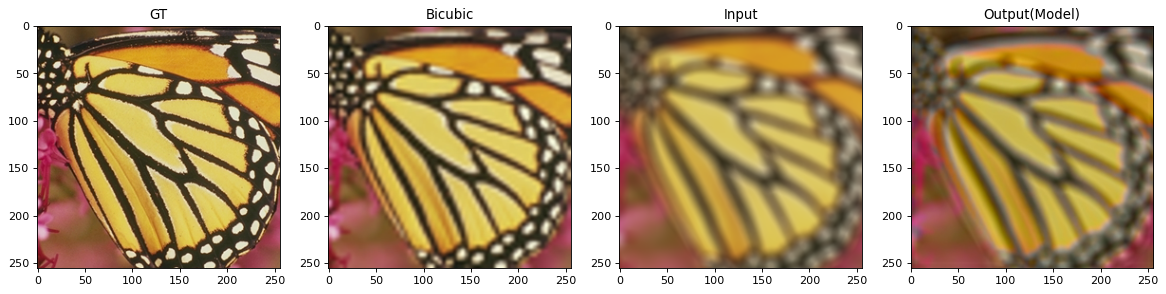

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7FB715A72BE0>,
 20.824648960041763,
 13.383639750705047)

In [46]:
display_PSNR(im_gt, im_b, im_b2, model)


In [47]:
im_gt.size

(256, 256)

In [48]:
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(height/scale), int(width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = Crappify(crop_size = None, kernel_size=scale*2, quality=90)(im_gt)# open image file
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 



psnr for bicubic is 20.90886905719583dB
psnr for Model is 20.21300642749496dB
PSNR improvement is -0.6958626297008692dB
Sharpness Measurement GroundTruth: 5109.0955266965975
Sharpness Measurement Bicubic: 15.83579055305556
Sharpness Measurement Input: 21.051232107708337
Sharpness Measurement Model: 20.656455114427082


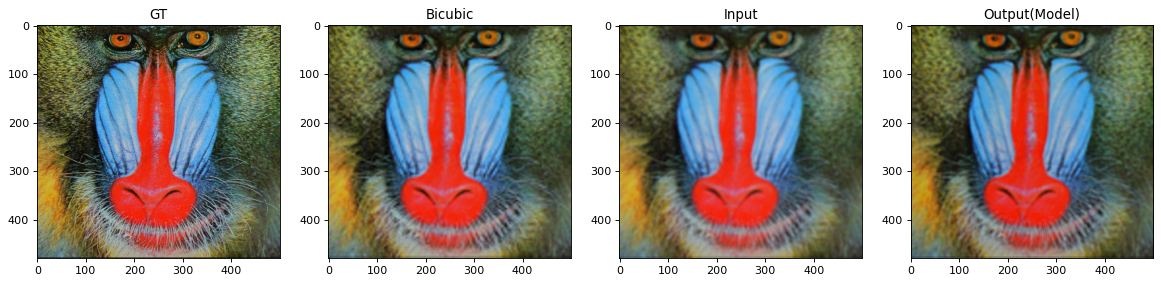

psnr for bicubic is 24.308655657370245dB
psnr for Model is 23.15822964985412dB
PSNR improvement is -1.1504260075161241dB
Sharpness Measurement GroundTruth: 1139.0247193743783
Sharpness Measurement Bicubic: 22.619108417905434
Sharpness Measurement Input: 17.99254485000458
Sharpness Measurement Model: 19.903298782057934


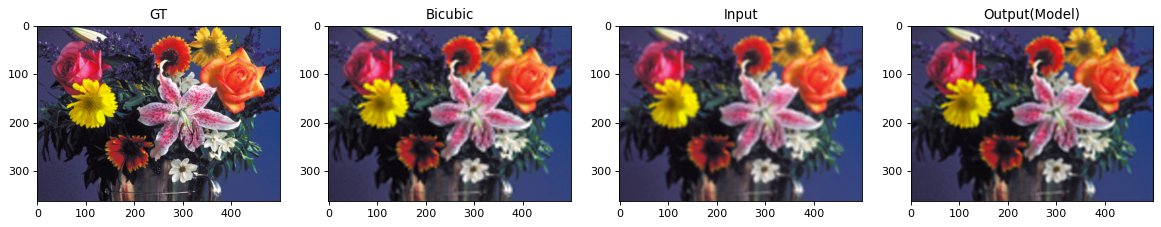

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 7.79 GiB total capacity; 4.27 GiB already allocated; 29.31 MiB free; 6.65 GiB reserved in total by PyTorch)

In [49]:
test_results("/media/SSD/superres/video_data/test_data/Set14", 4, display = True)

# convert sample videos

In [36]:
result_path

PosixPath('/media/SSD/superres/Results/Superresolution train RCAN with hres perception loss multifuz')

In [37]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-12.mp4"
superres_mp4(infile, outfile, model, factor=1.2,display=False,bitrate= "4000k")

  0%|          | 1/900 [00:00<02:26,  6.15it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train RCAN with hres perception loss multifuz/muffins30sec-12.mp4
factor: 1.2 
width= 384 
height= 288 
bitrate= 4000k


100%|██████████| 900/900 [02:09<00:00,  6.93it/s]


True

In [36]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train RCAN with hres perception loss multifuz/muffins30sec-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:55<00:00, 16.36it/s]


True

In [39]:
dualfile= str(result_path/"muffins30sec-10dual.mp4")
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = str(result_path/"muffins30sec-10.mp4")

In [43]:
# original scale , for video x3
!ffmpeg  -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw:ih [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, model, factor=2.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, model, factor=3.0,display=False,bitrate= "4000k")


In [ ]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz/super8hespcn1.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = result_file/"super8long.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:
dualfile= folder + "super8longespcn2dual.mp4"
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}